In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

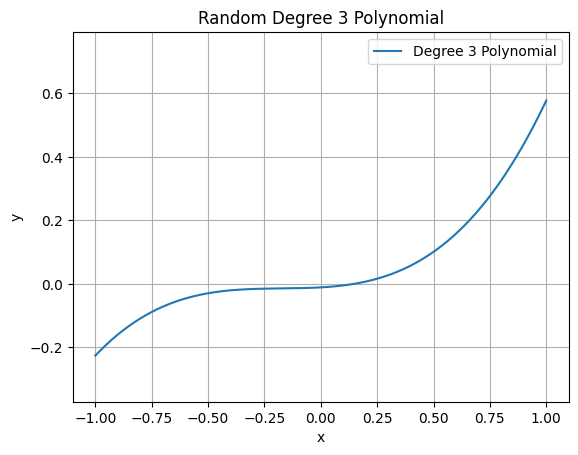

In [2]:
########
### change this 
# Percentage of data points to add outliers to.
outlier_ratio = 0.3

# Randomly generate parameters of a polynomial of degree k (odd)
degree = 3

#########
coefficients = np.random.rand(degree + 1) - 0.5  # -0.5 ~ 0.5 Random values ​​in a range

# Set value range for x
@dataclass
class Range:
    min: float = -1.0  # Set default to -10
    max: float = 1.0   # Set default to 10

x_range = Range()
x = np.linspace(x_range.min, x_range.max, 400)

# Calculating y value with polynomial. 
# For example, coefficients = [a, b, c]. It will return $y = ax^2 + bx + c$
y = np.polyval(coefficients, x)
y_range = Range(min=1.2*np.min(y) - 0.1, max=1.2*np.max(y) + 0.1)
plt.plot(x, y, label=f'Degree {degree} Polynomial')
plt.title(f'Random Degree {degree} Polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.ylim(y_range.min, y_range.max)
plt.show()

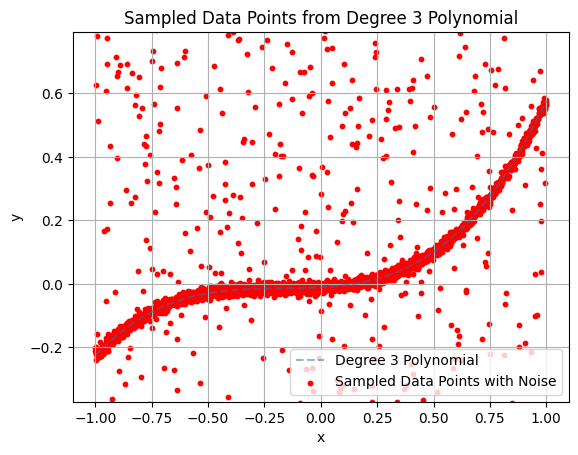

In [3]:
# true data point 1000 
# Sampling a dataset from a curve. The data number is `num_measurements`
num_measurements = 3000

x_samples = np.linspace(x_range.min, x_range.max, num_measurements)
y_samples = np.polyval(coefficients, x_samples)

# Add noise only to k% of random points
num_noisy_points = int(num_measurements * outlier_ratio)  # Number of data points to add noise to

# Choose a random index to add noise to
noisy_indices = np.random.choice(num_measurements, num_noisy_points, replace=False)

# Initialize all data points to noise 0
noise = np.zeros(num_measurements)

# Define the standard deviation of a very small amount of noise to add to the unselected data points.
small_noise_std = 0.01

# First add a very small amount of noise to every data point
small_noise = np.random.normal(0, small_noise_std, num_measurements)
y_samples_noisy = y_samples + small_noise

# Add originally defined noise to selected data points
white_noise_mean1 = 0.5
big_noise_std1 = 1.0
white_noise_mean2 = -0.2
big_noise_std2 = 0.5
y_samples_noisy[noisy_indices] += np.random.normal(white_noise_mean1, big_noise_std1, len(noisy_indices))
y_samples_noisy[noisy_indices] += np.random.normal(white_noise_mean2, big_noise_std2, len(noisy_indices))
# 샘플링한 데이터 포인트와 노이즈가 추가된 데이터 포인트 그리기
plt.plot(x, y, label=f'Degree {degree} Polynomial', linestyle='--', alpha=0.5)
plt.scatter(x_samples, y_samples_noisy, color='red', s=10, label='Sampled Data Points with Noise')
plt.title(f'Sampled Data Points from Degree {degree} Polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim(y_range.min, y_range.max)
plt.grid(True)
plt.show()

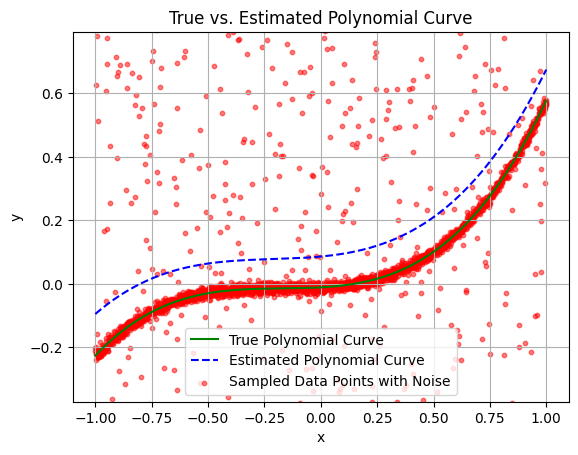

In [4]:
from scipy.linalg import lstsq

# Create matrix A and vector b
# Create Vandermonde matrix based on x_samples
A = np.vander(x_samples, N=degree+1)

# b is the sampled data point with added noise
b = y_samples_noisy

# Solve the linear system Ax = b to find x(coefficients)
coefficients_estimated, _, _, _ = lstsq(A, b)

# Generate predicted curves
y_estimated = np.polyval(coefficients_estimated, x_samples)

# Draw original curve (no noise) and predicted curve
plt.plot(x_samples, y_samples, color='green', label='True Polynomial Curve')
plt.plot(x_samples, y_estimated, color='blue', linestyle='--', label='Estimated Polynomial Curve')
plt.scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, label='Sampled Data Points with Noise')
plt.title('True vs. Estimated Polynomial Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim(y_range.min, y_range.max)
plt.grid(True)
plt.show()

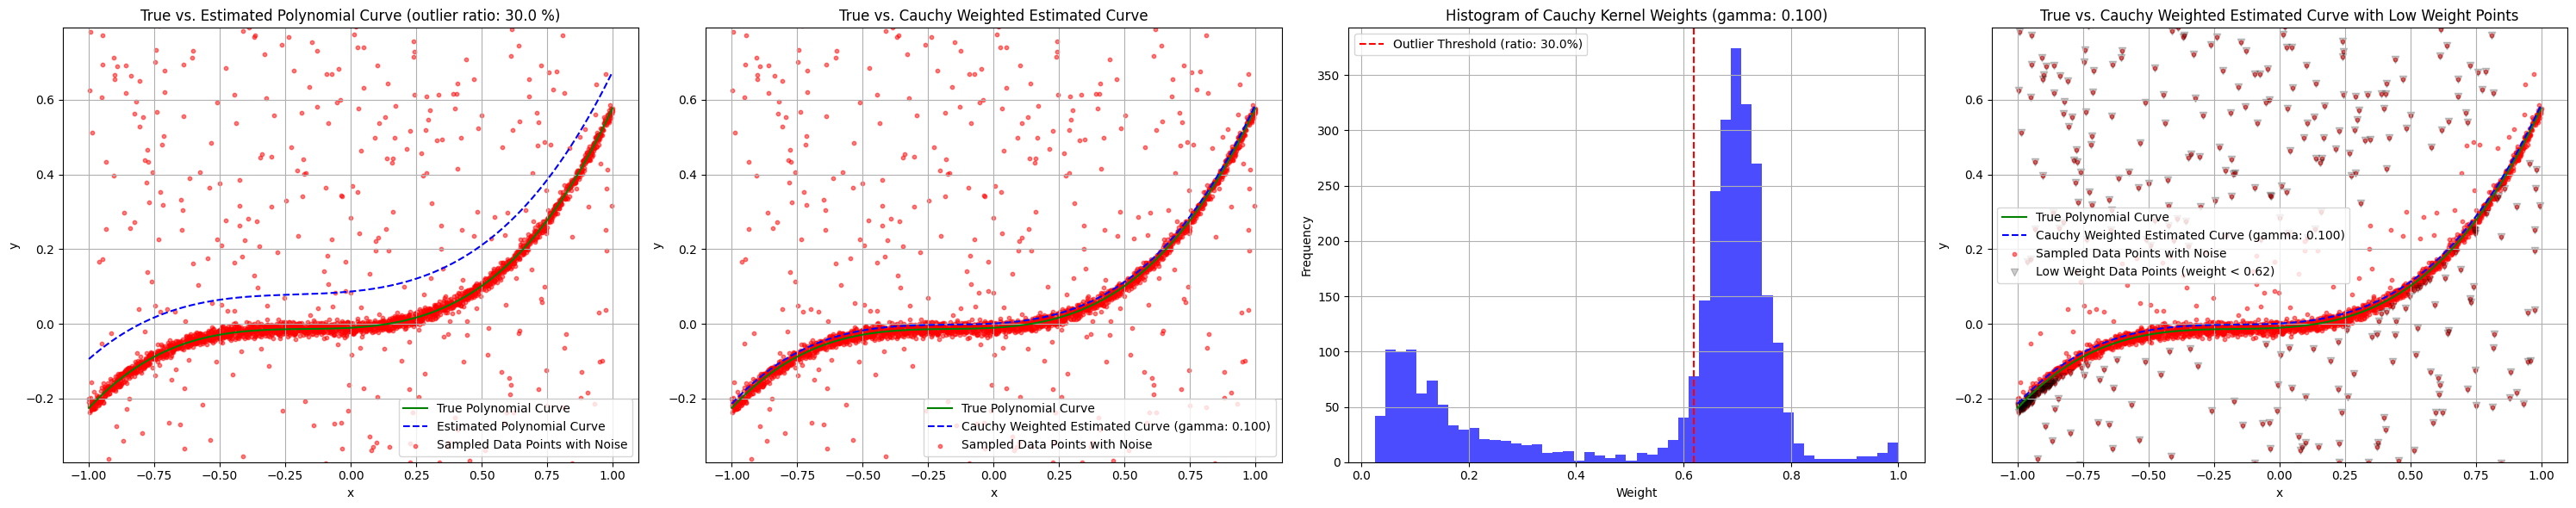

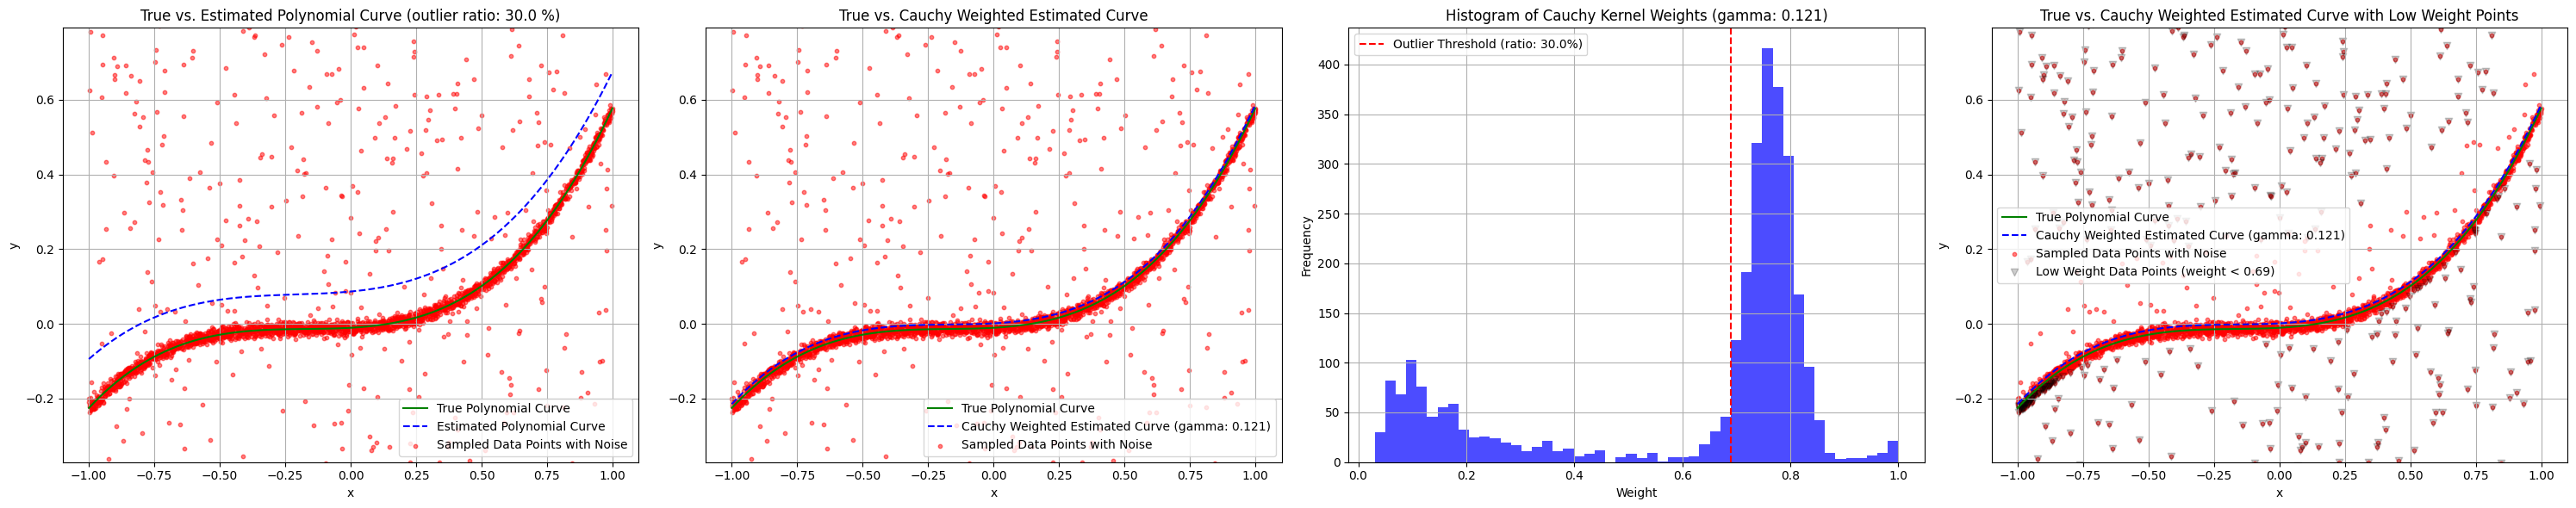

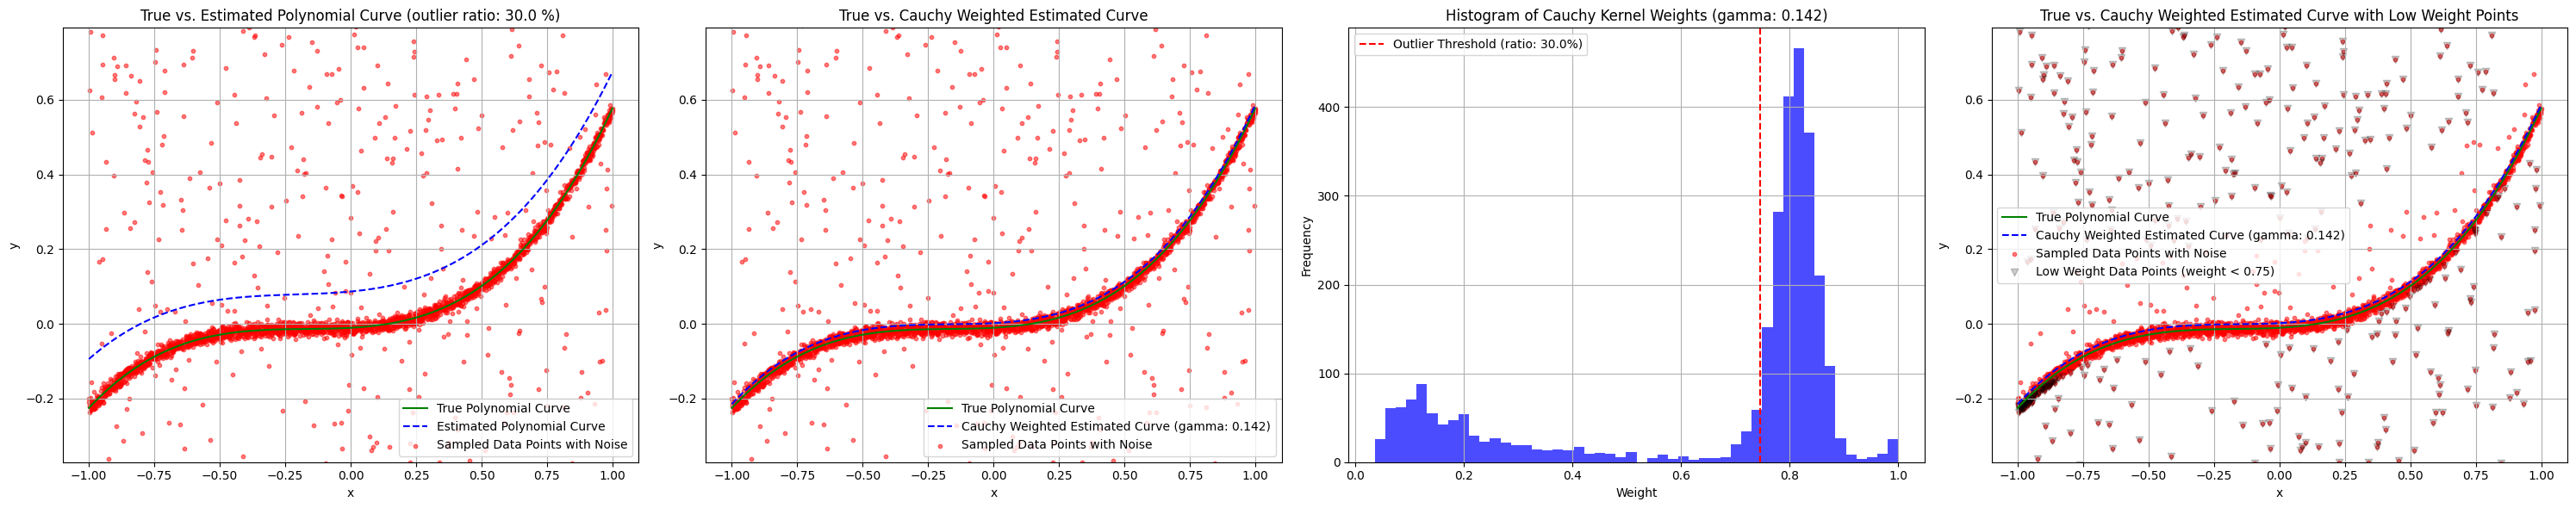

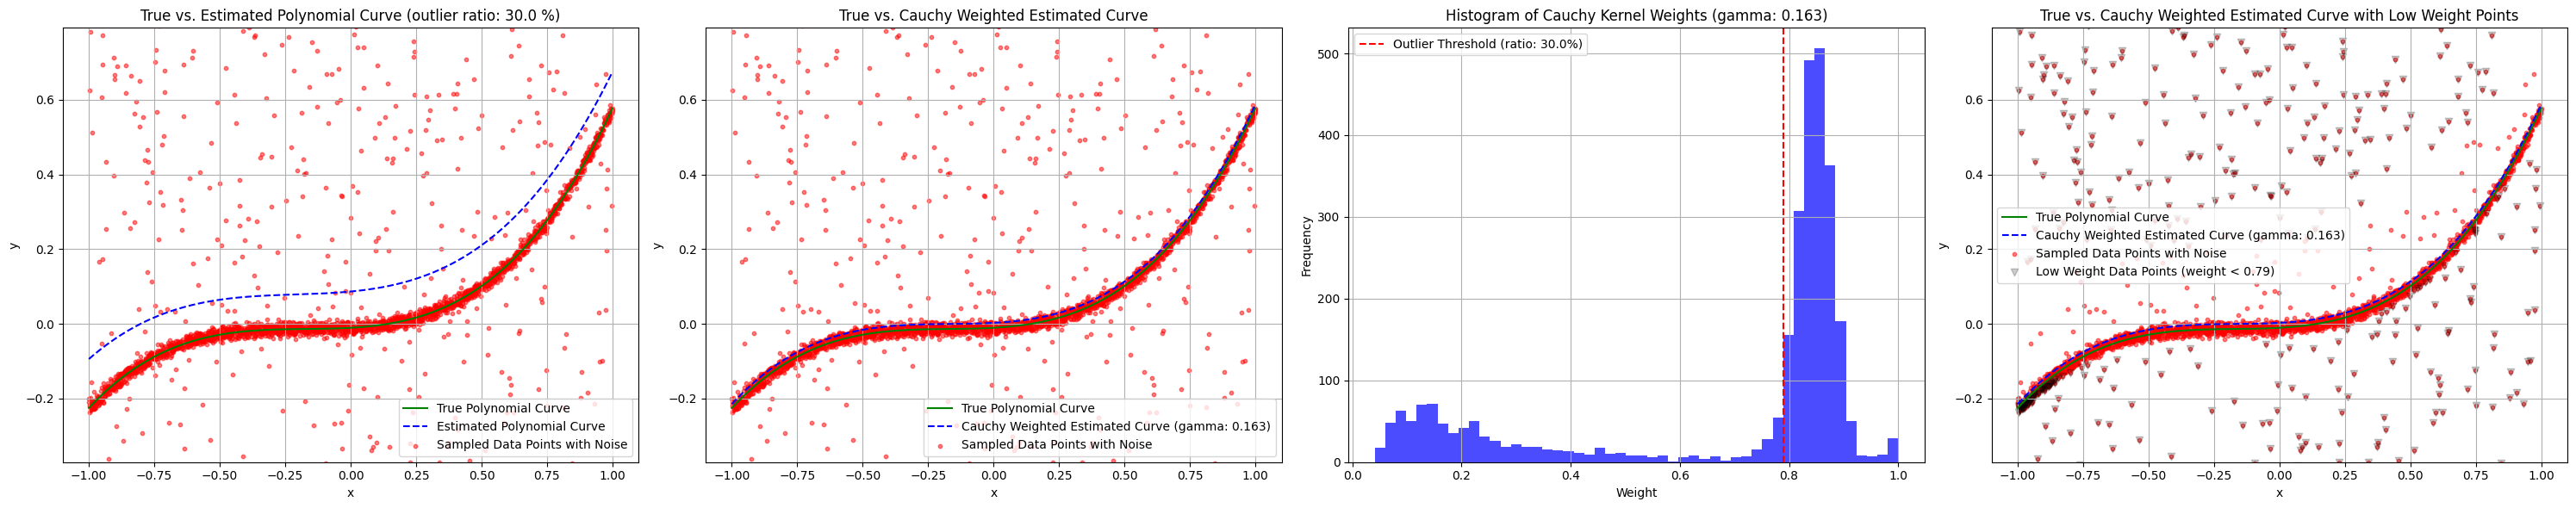

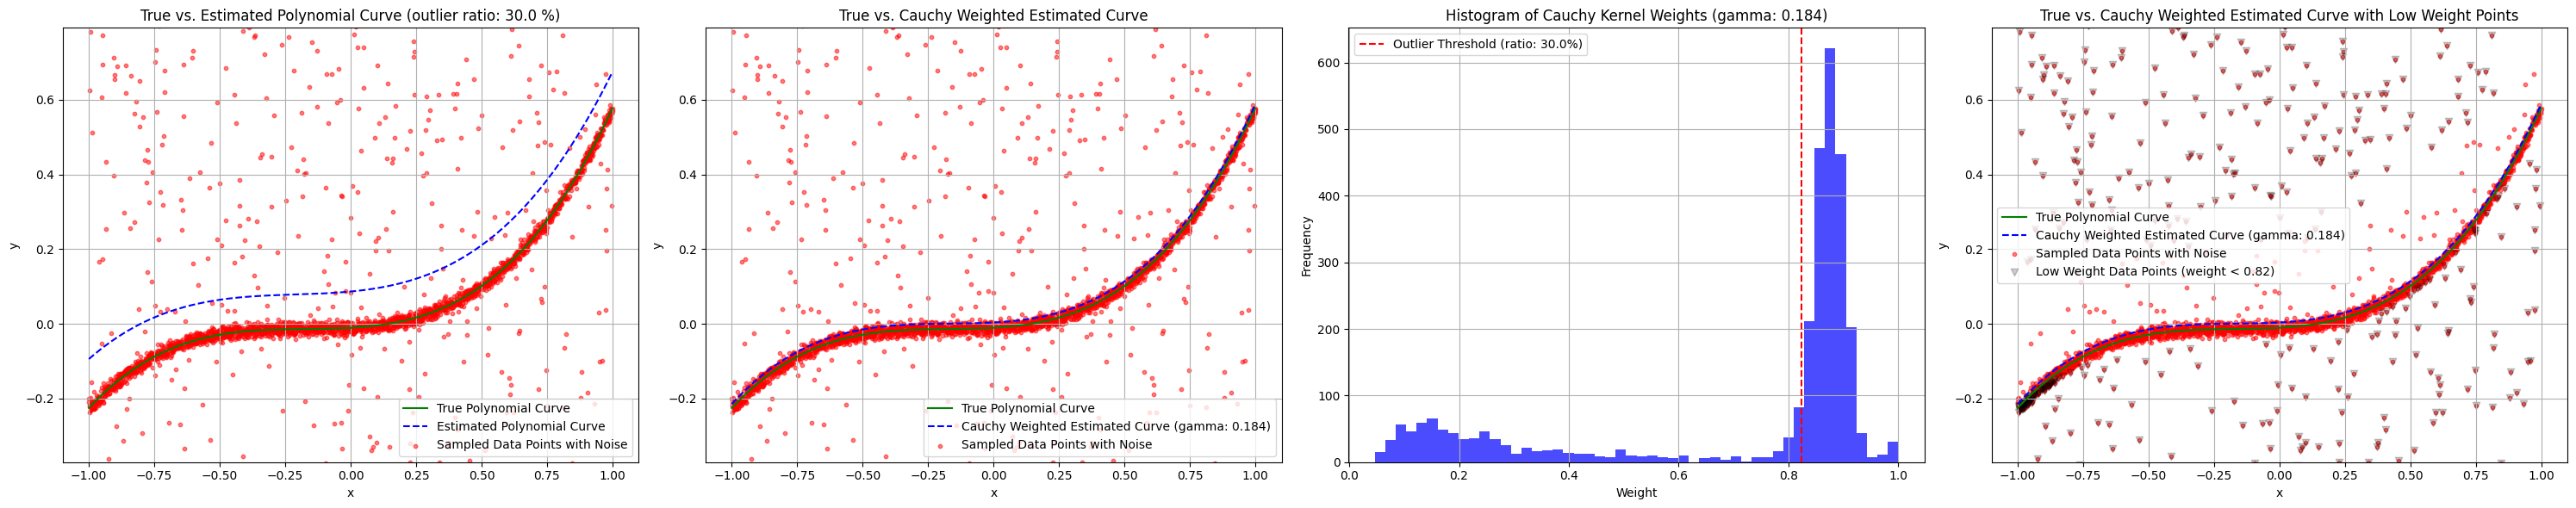

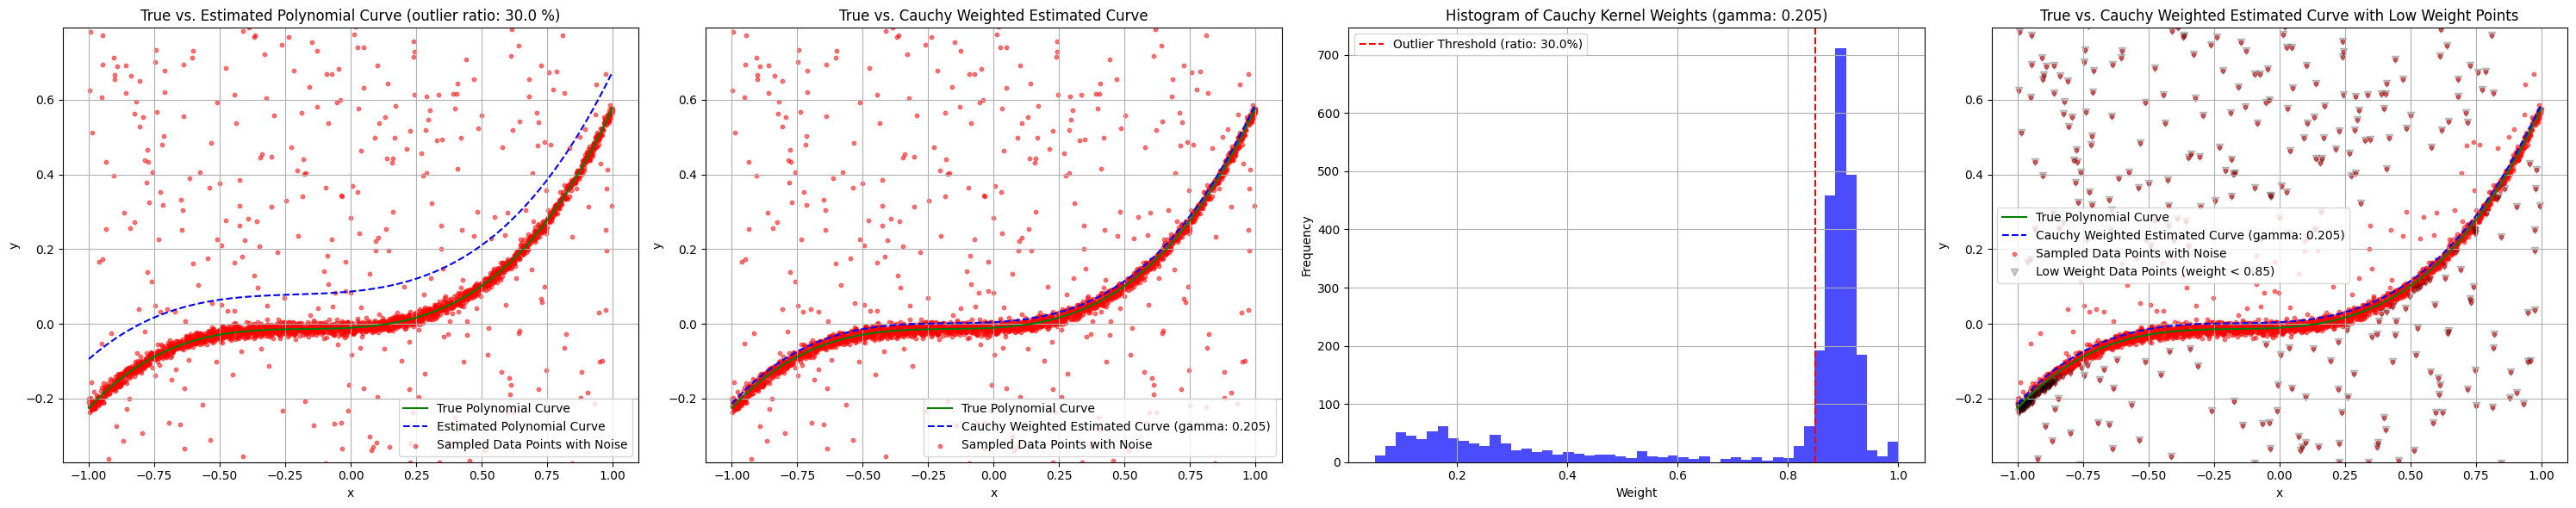

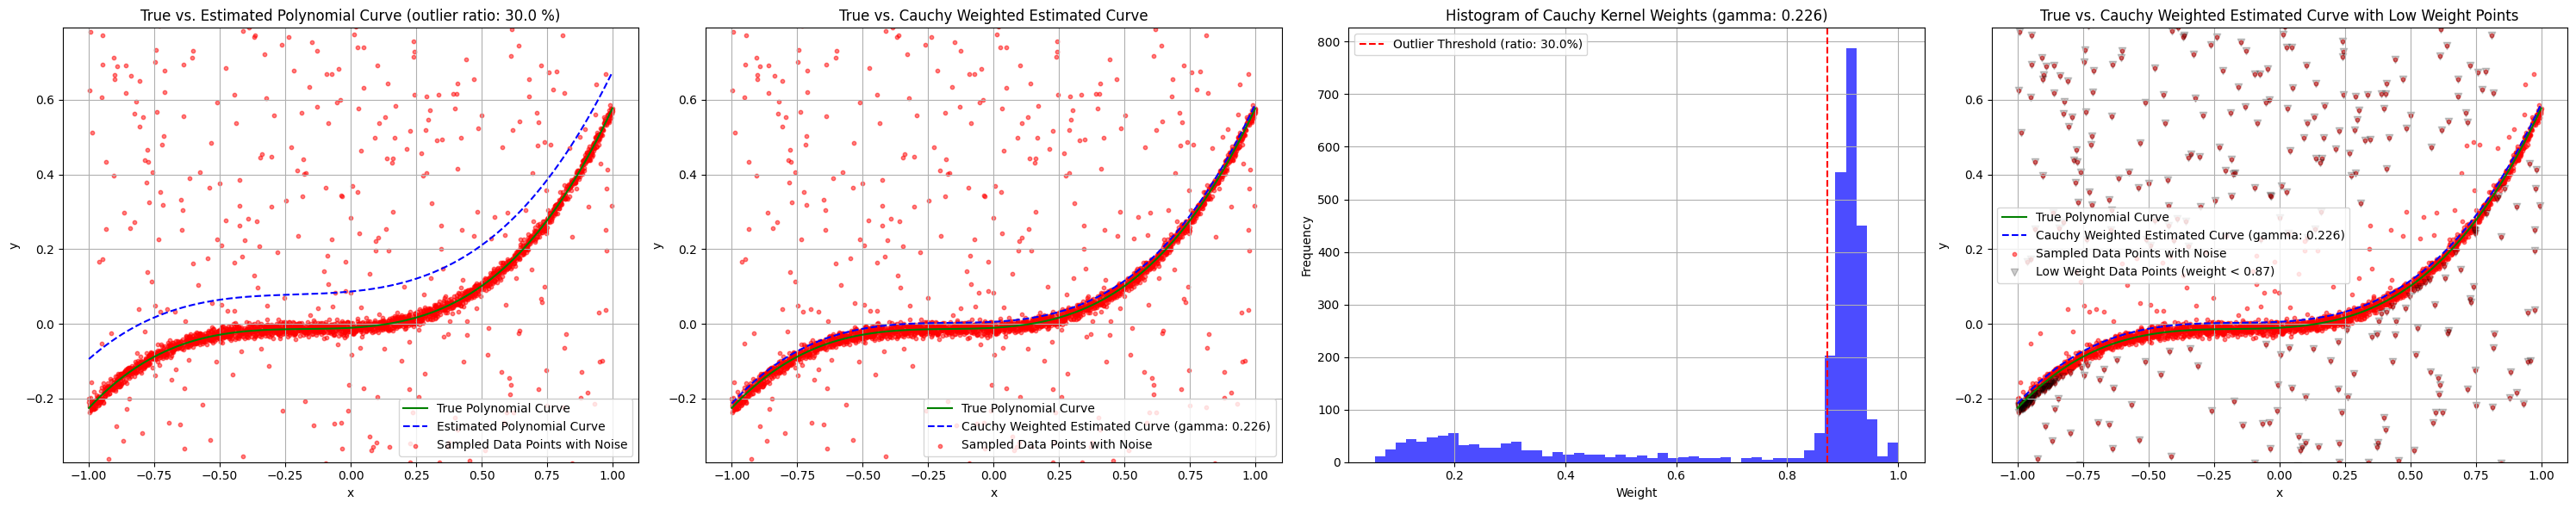

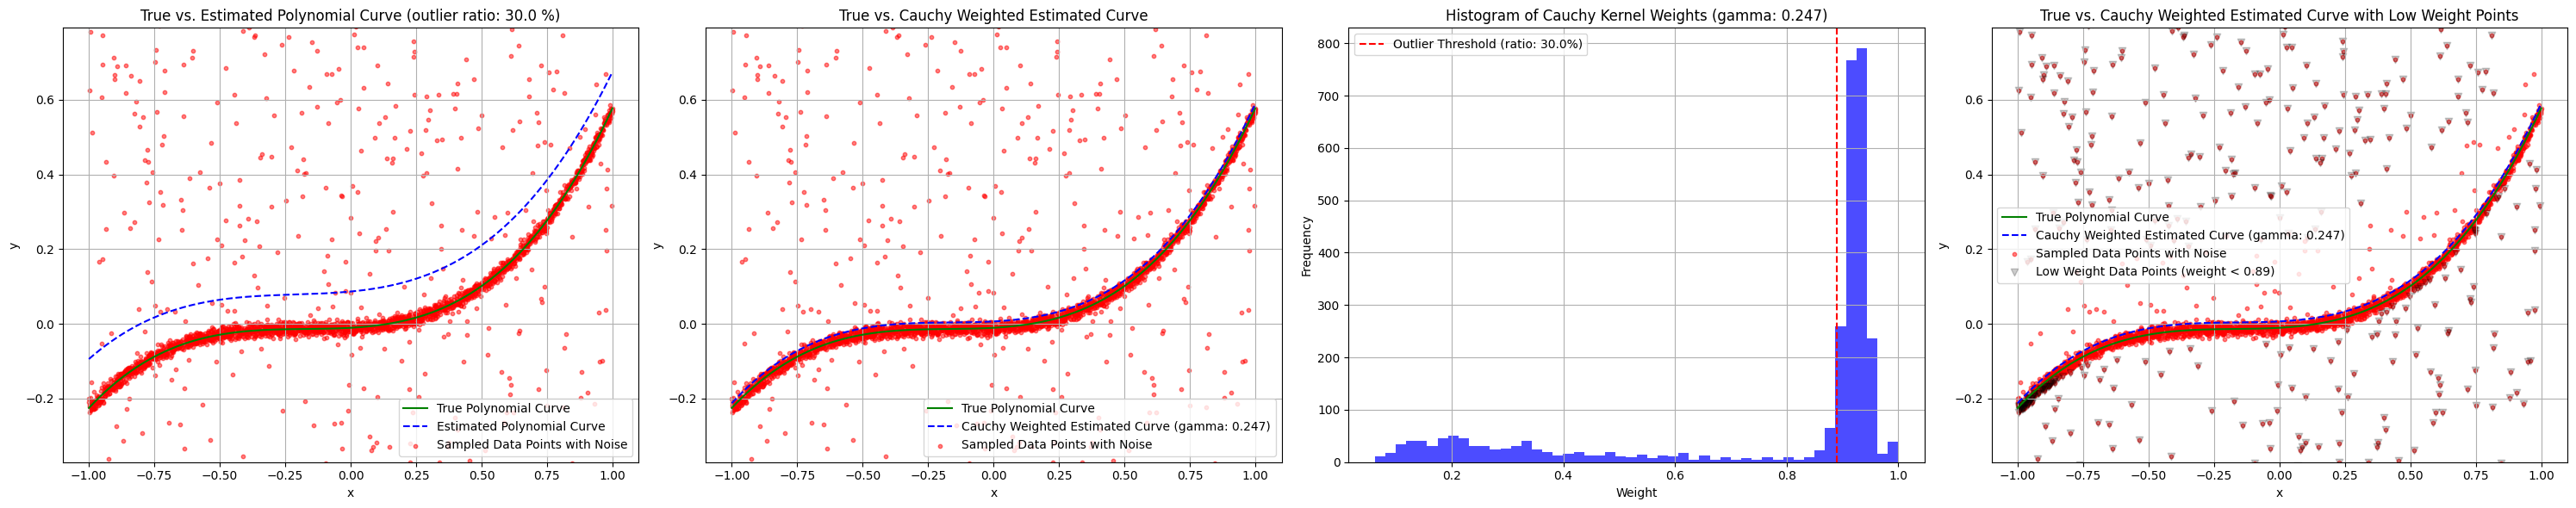

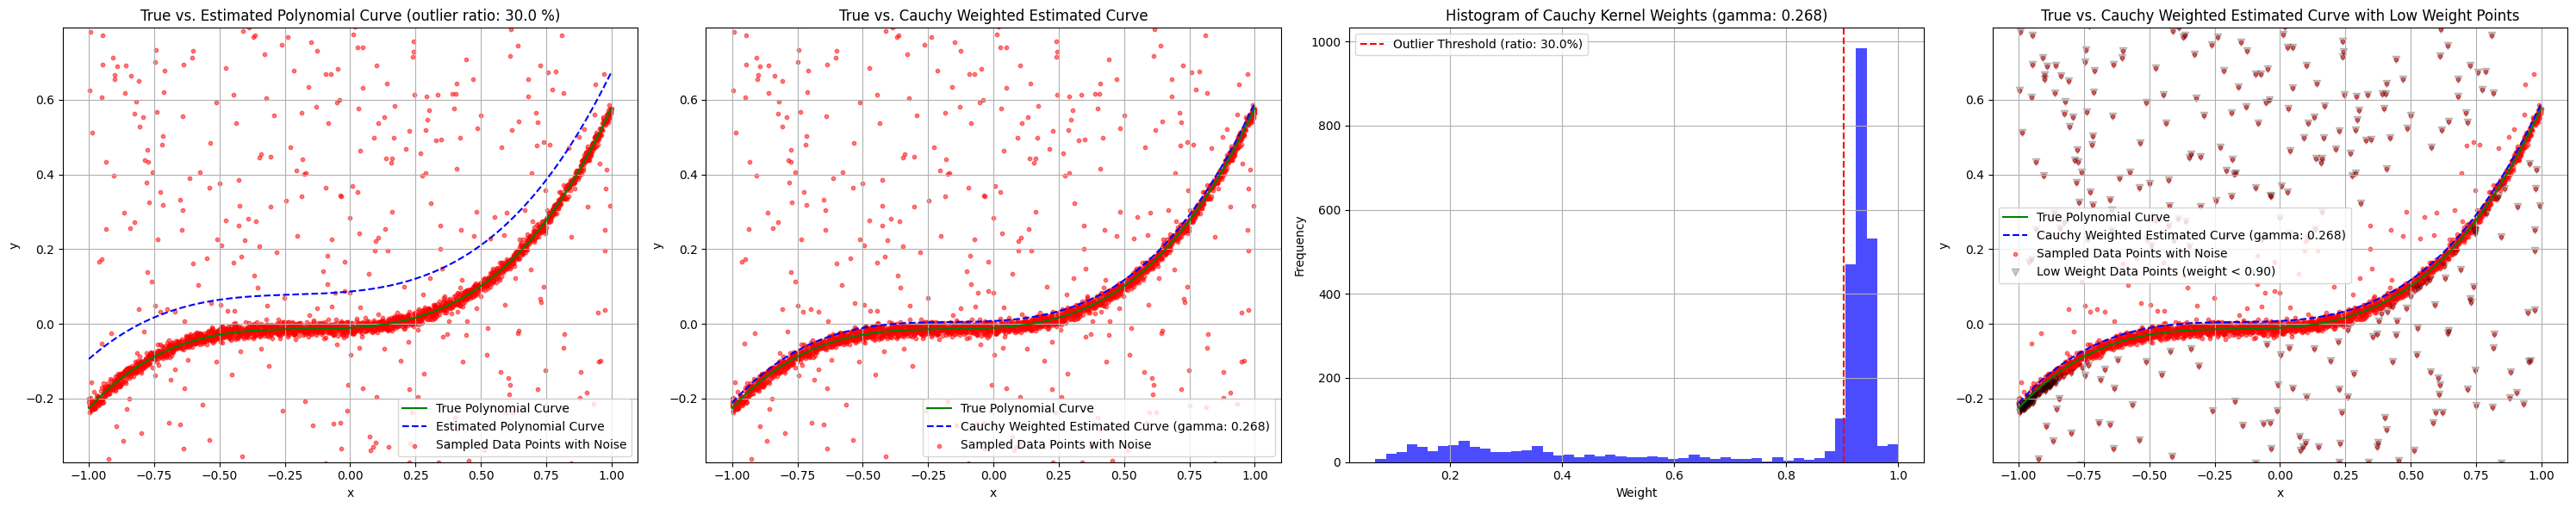

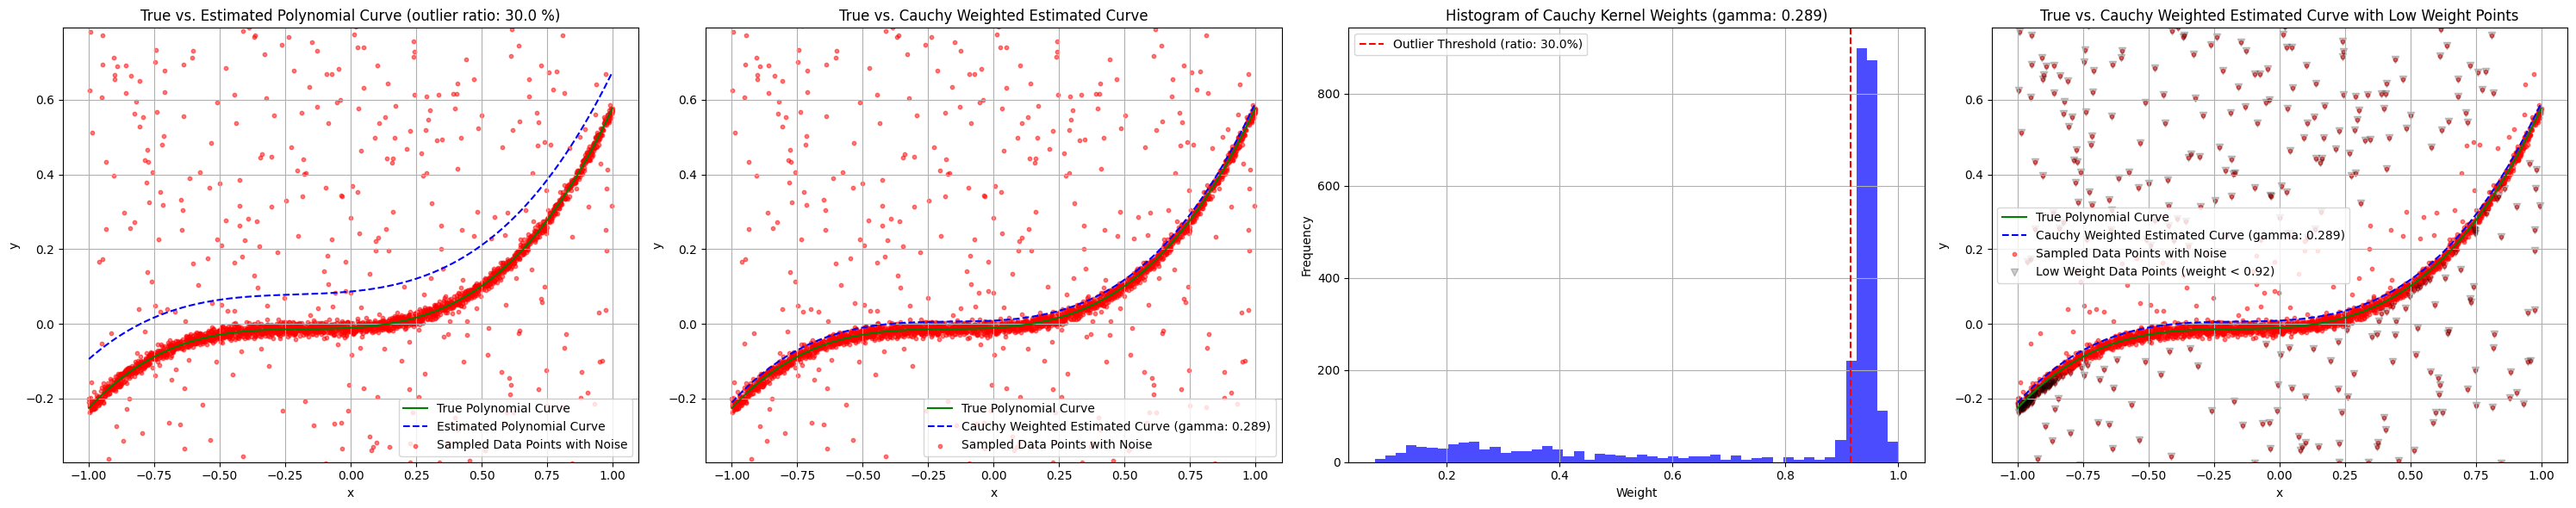

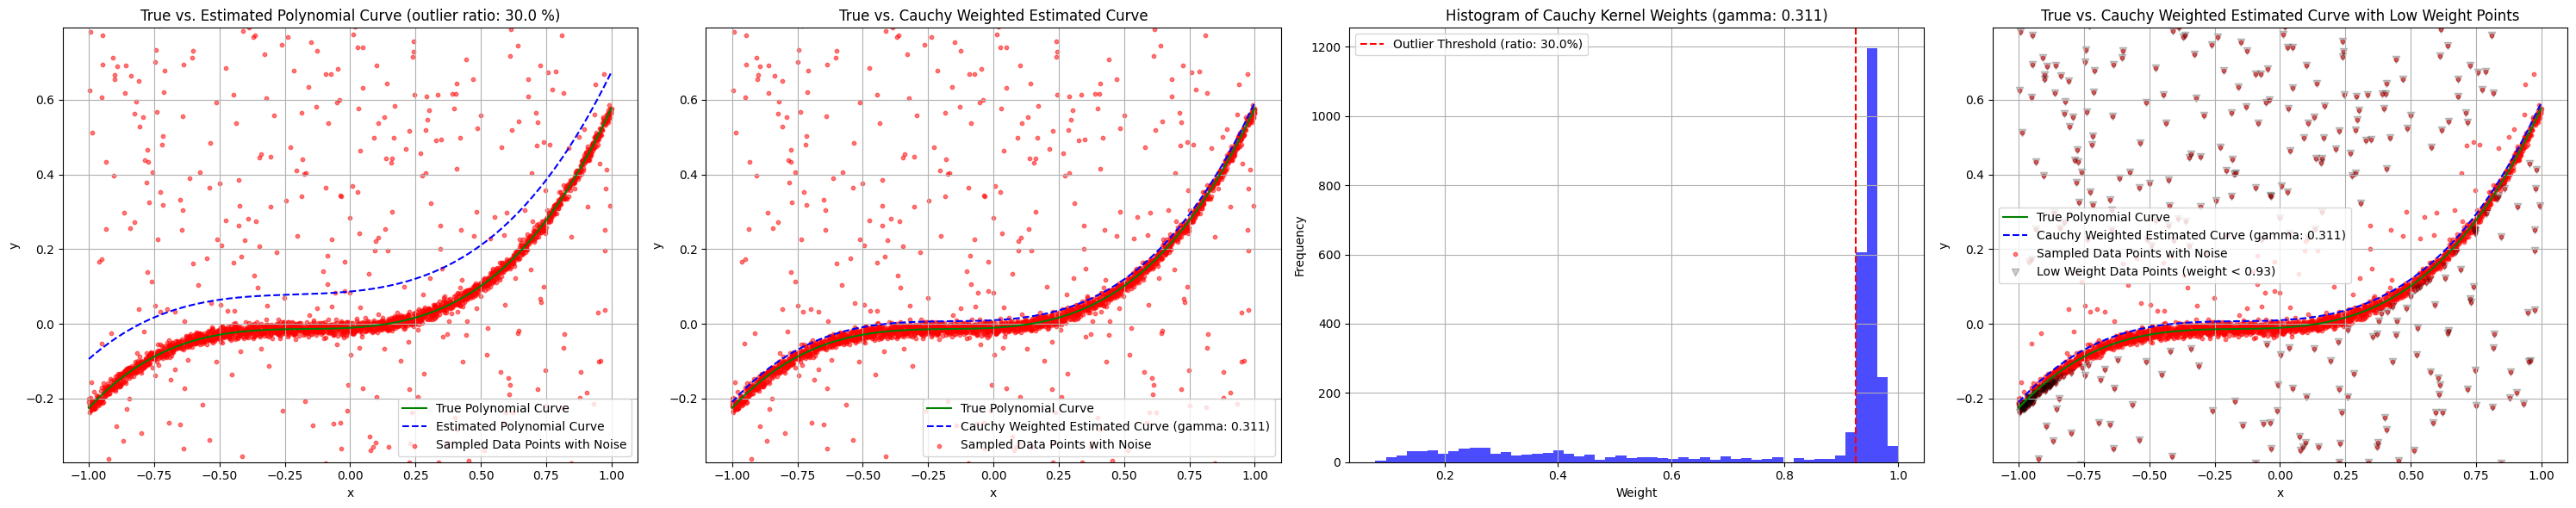

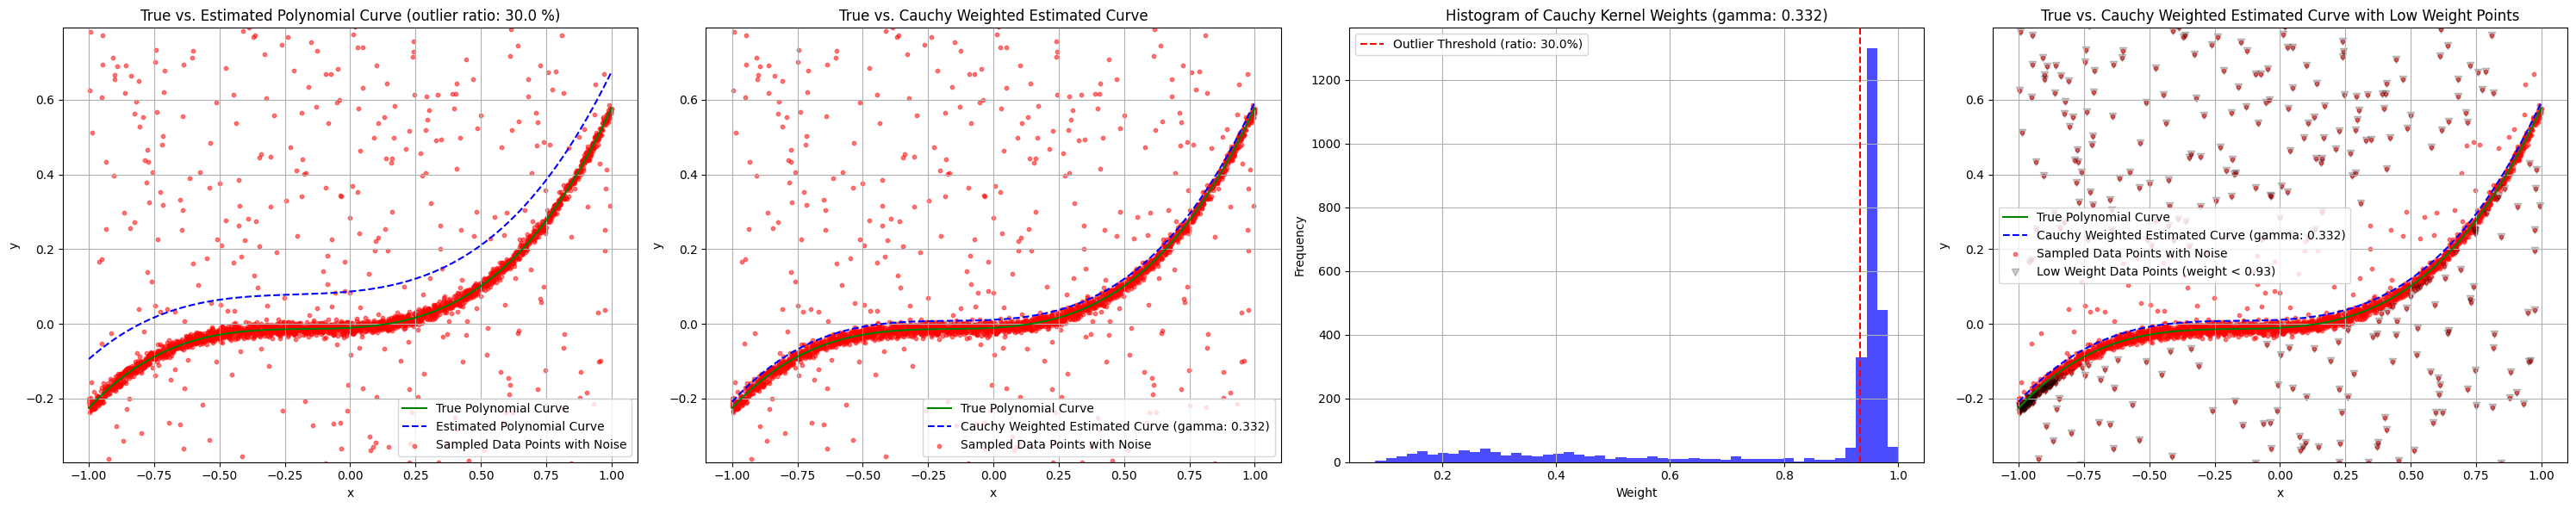

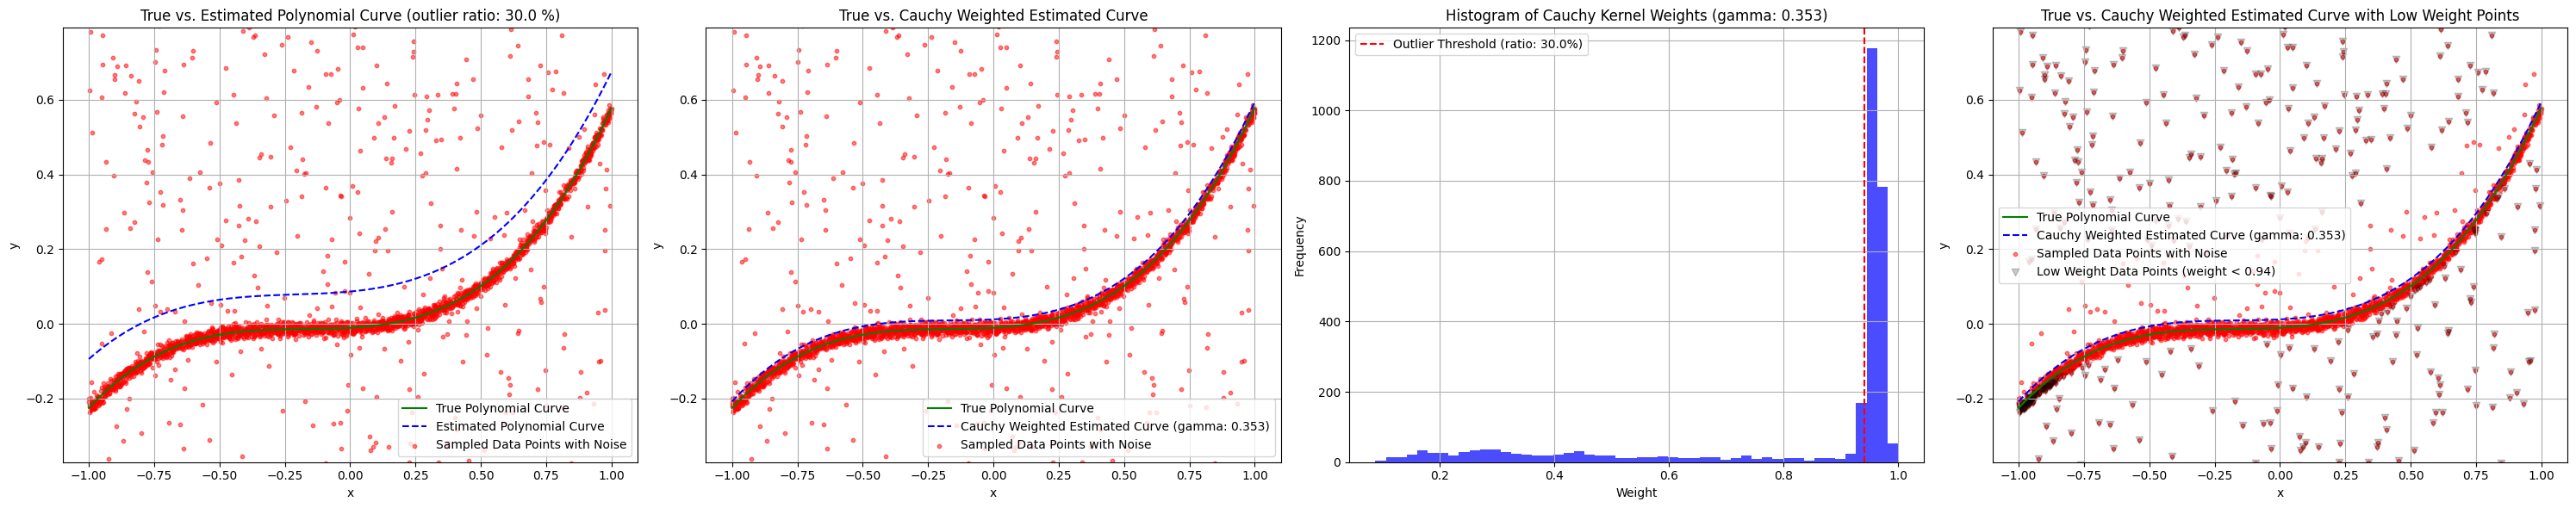

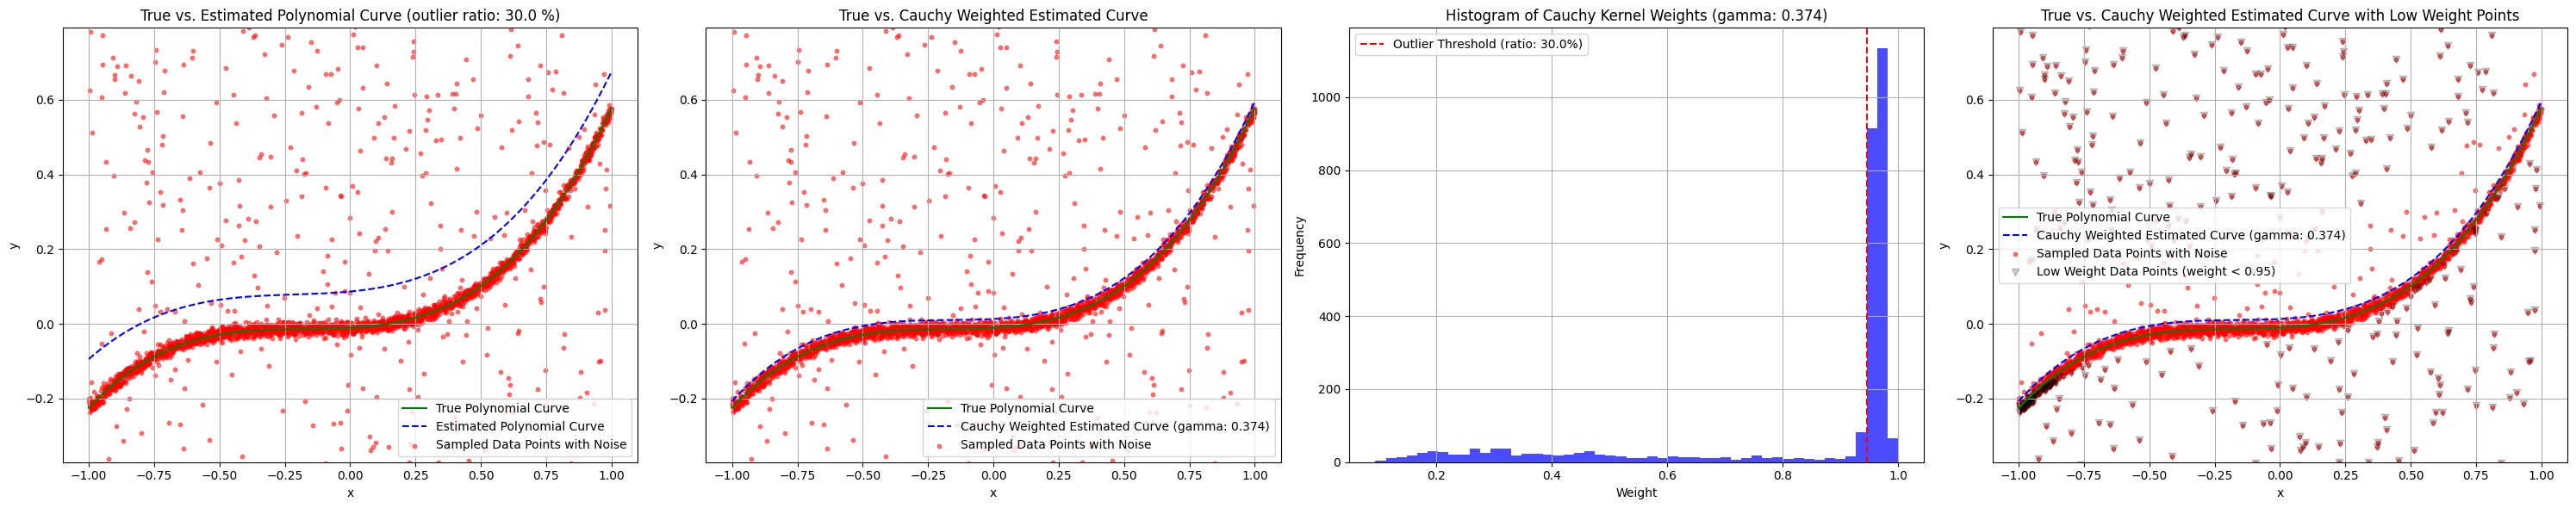

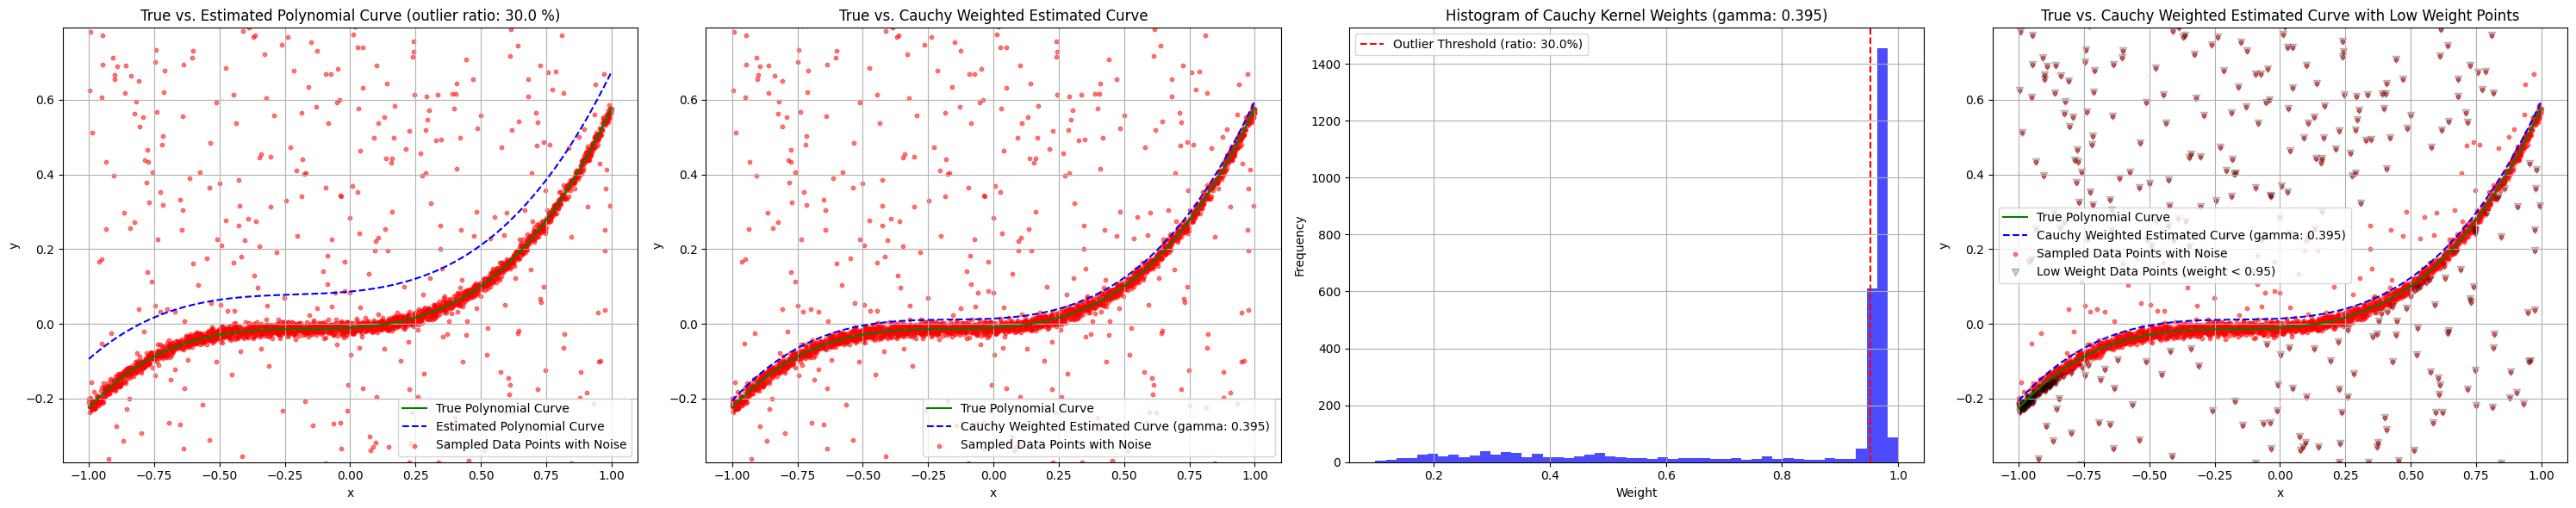

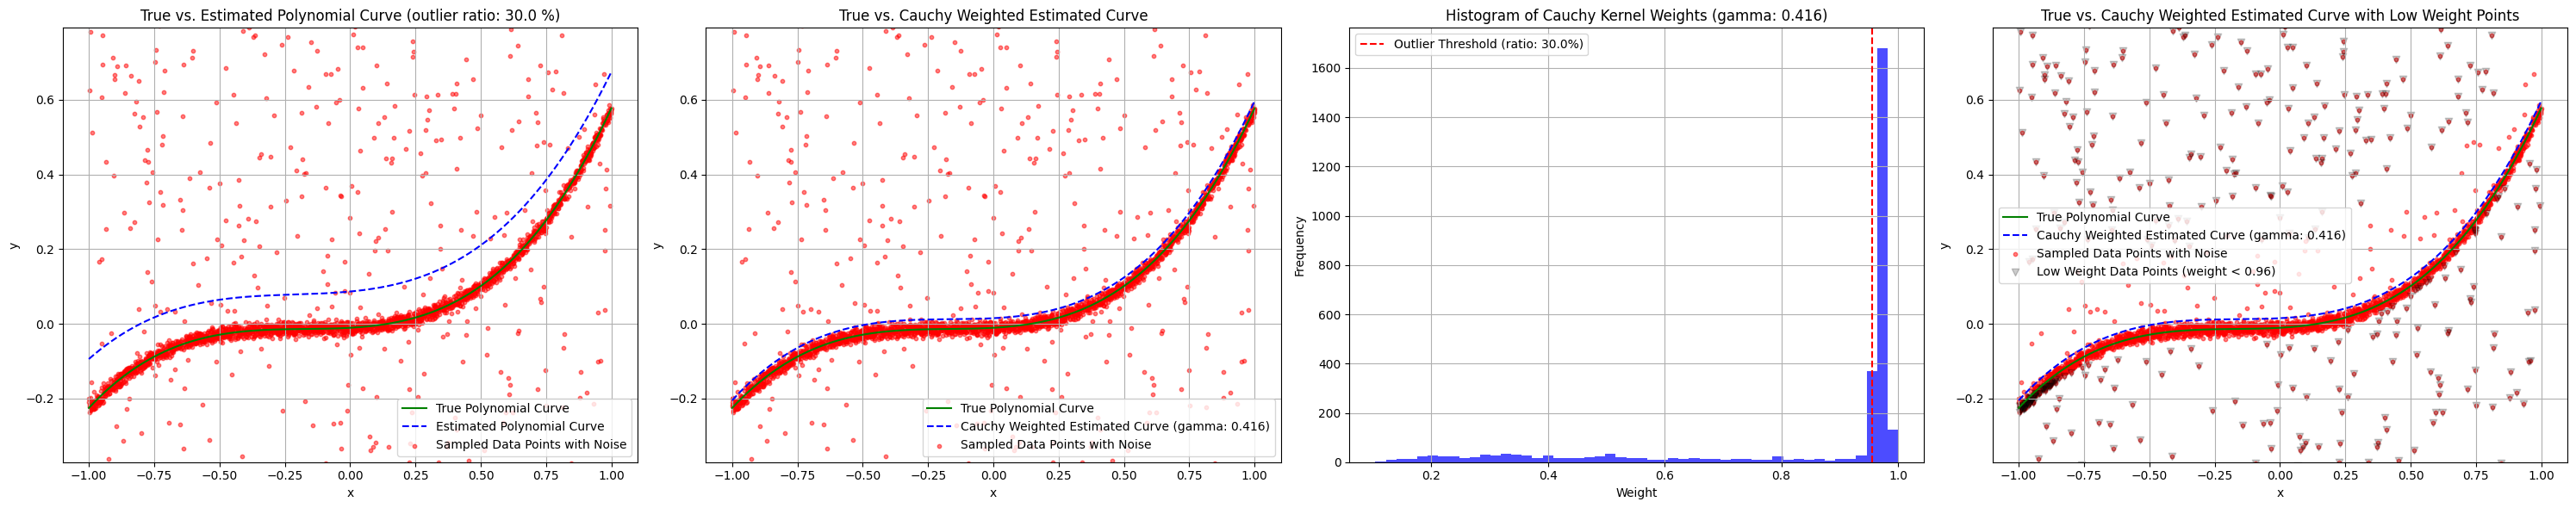

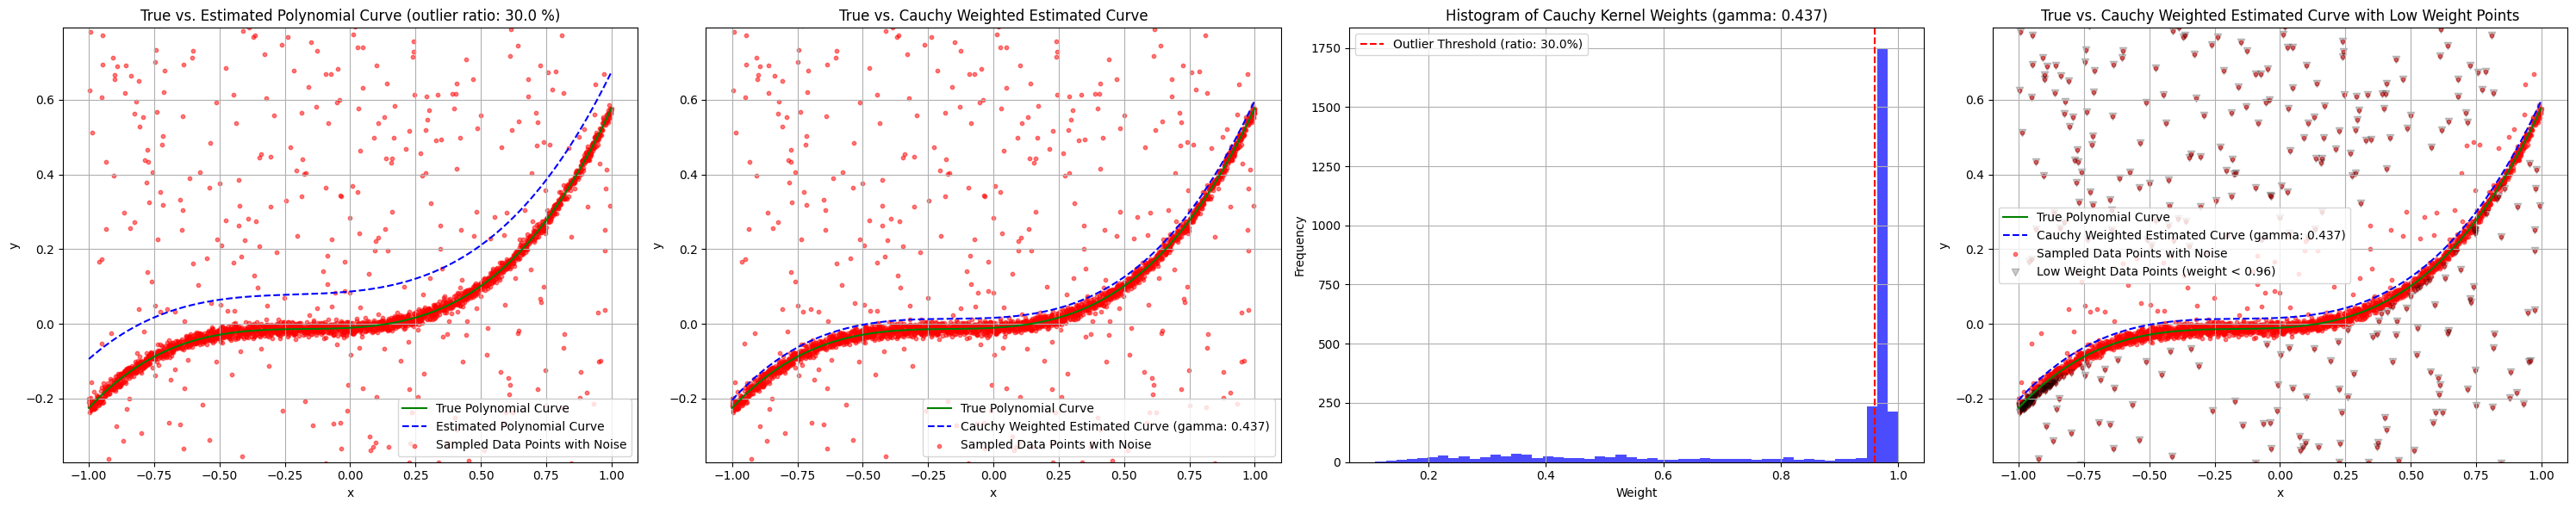

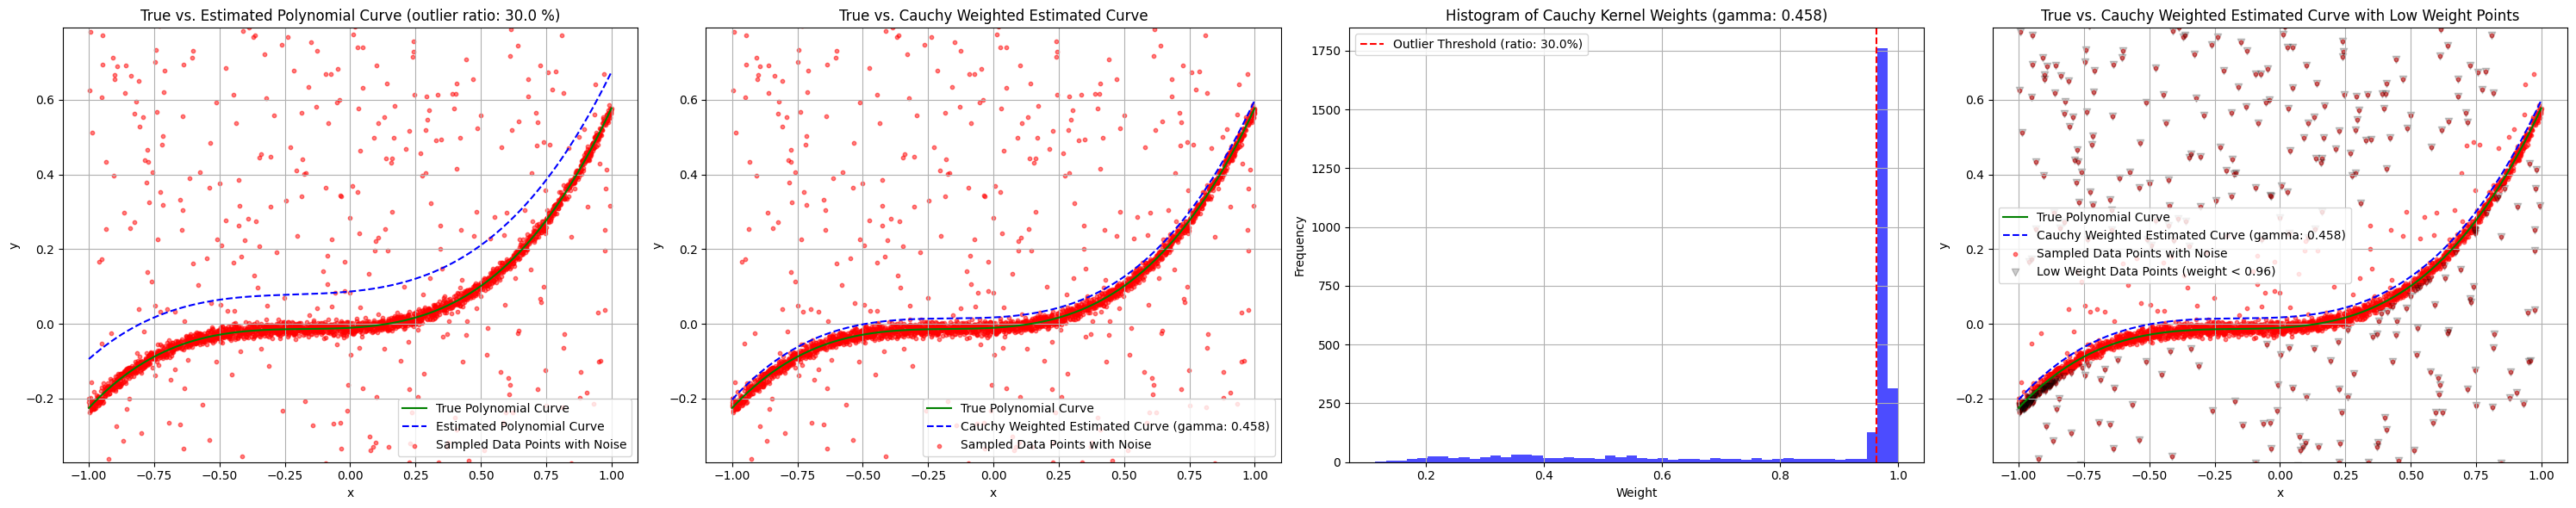

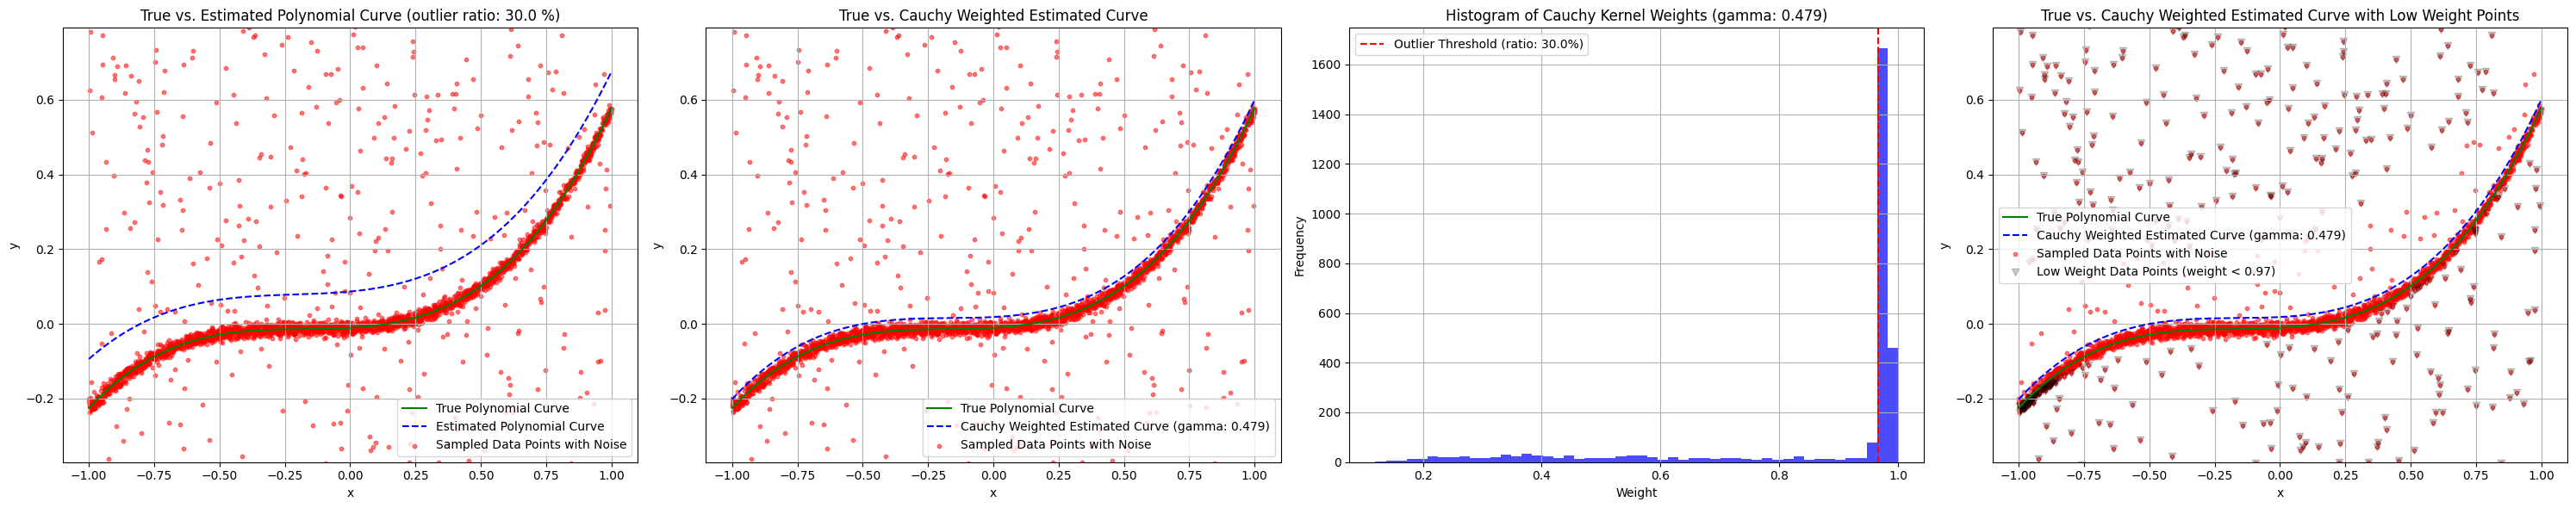

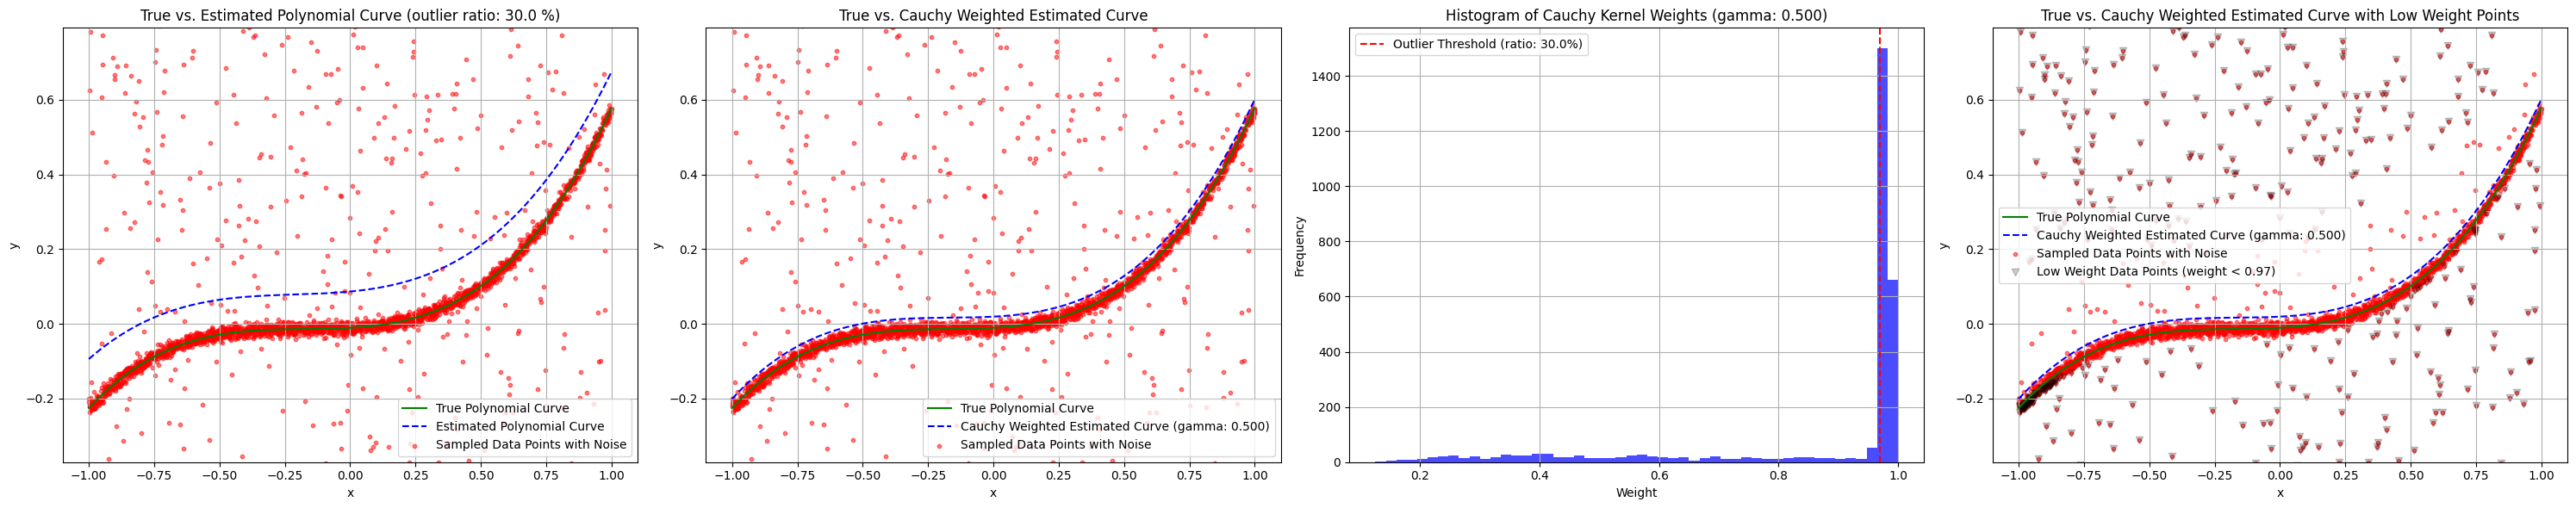

In [5]:
# Scale parameter of the Cauchy kernel that can be adjusted to fit the data.
for gamma in np.linspace(0.1, 0.5, 20):
    # Calculate initial predictions (here we use simple least squares)
    coefficients_initial, _, _, _ = lstsq(A, b)
    y_initial_predicted = np.polyval(coefficients_initial, x_samples)

    # Calculating Cauchy kernel weights
    residuals_initial = y_samples_noisy - y_initial_predicted
    weights_cauchy = 1 / (1 + (residuals_initial / gamma) ** 2)
    weights_cauchy = np.sqrt(weights_cauchy) # empirically much smoother converge 

    # Apply weights
    W_cauchy = np.diag(weights_cauchy)
    WA_cauchy = W_cauchy @ A
    Wb_cauchy = W_cauchy @ b

    # Solving weighted linear systems
    coefficients_cauchy, _, _, _ = lstsq(WA_cauchy, Wb_cauchy)

    # Generate weighted predicted curves
    y_cauchy_estimated = np.polyval(coefficients_cauchy, x_samples)

    # Create a single figure for the subplots with a width equal to your monitor's width
    fig, axes = plt.subplots(1, 4, figsize=(30, 6))

    # Plot 1: True vs. Estimated Polynomial Curve
    axes[0].plot(x_samples, y_samples, color='green', label='True Polynomial Curve')
    axes[0].plot(x_samples, y_estimated, color='blue', linestyle='--', label='Estimated Polynomial Curve')
    axes[0].scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, label='Sampled Data Points with Noise')
    axes[0].set_title(f'True vs. Estimated Polynomial Curve (outlier ratio: {outlier_ratio*100:.1f} %)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend()
    axes[0].set_ylim(y_range.min, y_range.max)
    axes[0].grid(True)

    # Plot 2: True vs. Cauchy Weighted Estimated Curve
    axes[1].plot(x_samples, y_samples, color='green', label='True Polynomial Curve')
    axes[1].plot(x_samples, y_cauchy_estimated, color='blue', linestyle='--', label=f'Cauchy Weighted Estimated Curve (gamma: {gamma:.3f})')
    axes[1].scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, label='Sampled Data Points with Noise')
    axes[1].set_title(f'True vs. Cauchy Weighted Estimated Curve')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_ylim(y_range.min, y_range.max)
    axes[1].legend()
    axes[1].grid(True)

    # Plot 3: Histogram of Cauchy Kernel Weights
    axes[2].hist(weights_cauchy, bins=50, color='blue', alpha=0.7)
    axes[2].set_title(f'Histogram of Cauchy Kernel Weights (gamma: {gamma:.3f})')
    axes[2].set_xlabel('Weight')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)
    # Calculate the threshold value for the outlier_ratio
    threshold = np.percentile(weights_cauchy, 100 * outlier_ratio)
    # Plot the threshold line on the histogram
    axes[2].axvline(x=threshold, color='red', linestyle='--', label=f'Outlier Threshold (ratio: {outlier_ratio * 100:.1f}%)')
    axes[2].legend()

    # Plot 4: True vs. Cauchy Weighted Estimated Curve with Low Weight Points
    # Find the indices of data points with weights less than k
    low_weight_indices = np.where(weights_cauchy < threshold)[0]
    # Extract x values ​​of data points with weights less than k
    x_low_weight = x_samples[low_weight_indices]
    y_low_weight_noisy = y_samples_noisy[low_weight_indices]
    axes[3].plot(x_samples, y_samples, color='green', label='True Polynomial Curve')
    axes[3].plot(x_samples, y_cauchy_estimated, color='blue', linestyle='--', label=f'Cauchy Weighted Estimated Curve (gamma: {gamma:.3f})')
    axes[3].scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, label='Sampled Data Points with Noise')
    axes[3].scatter(x_low_weight, y_low_weight_noisy, color='black', marker='v', alpha=0.2, label=f'Low Weight Data Points (weight < {threshold:.2f})')
    axes[3].set_title(f'True vs. Cauchy Weighted Estimated Curve with Low Weight Points')
    axes[3].set_xlabel('x')
    axes[3].set_ylabel('y')
    axes[3].set_ylim(y_range.min, y_range.max)
    axes[3].legend()
    axes[3].grid(True)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Display the combined figure
    plt.show()

Summary from the video

* The increase of `gamma` is a engineer's work. It is better to understand the domain data's characteristics and outlier pattern if avaiable. 
* When the `gamma` increased, the weight ditributtion shape is moving (3rd column). 
* But the estimated curve is still not good and **not improved** iteratively. 
* If the outlier ratio is big, it increase `gamma` can not be a solution. 

Conclusion

* Only applying just robust kernel (fixed or somewhat varying hyper params with give range) can not be a solution if the outlier ratio is big. 
* The robust kernel based deweighting is sometimes callerd "implicit outlier removal".

Next, we will try to add "explicit outlier removal strategy". The main idea is to **remove the low-weighted data point iteratively**. 

Try 0 remained num datapoints: 3000
weight_threshold_for_outlier_removal: 0.081


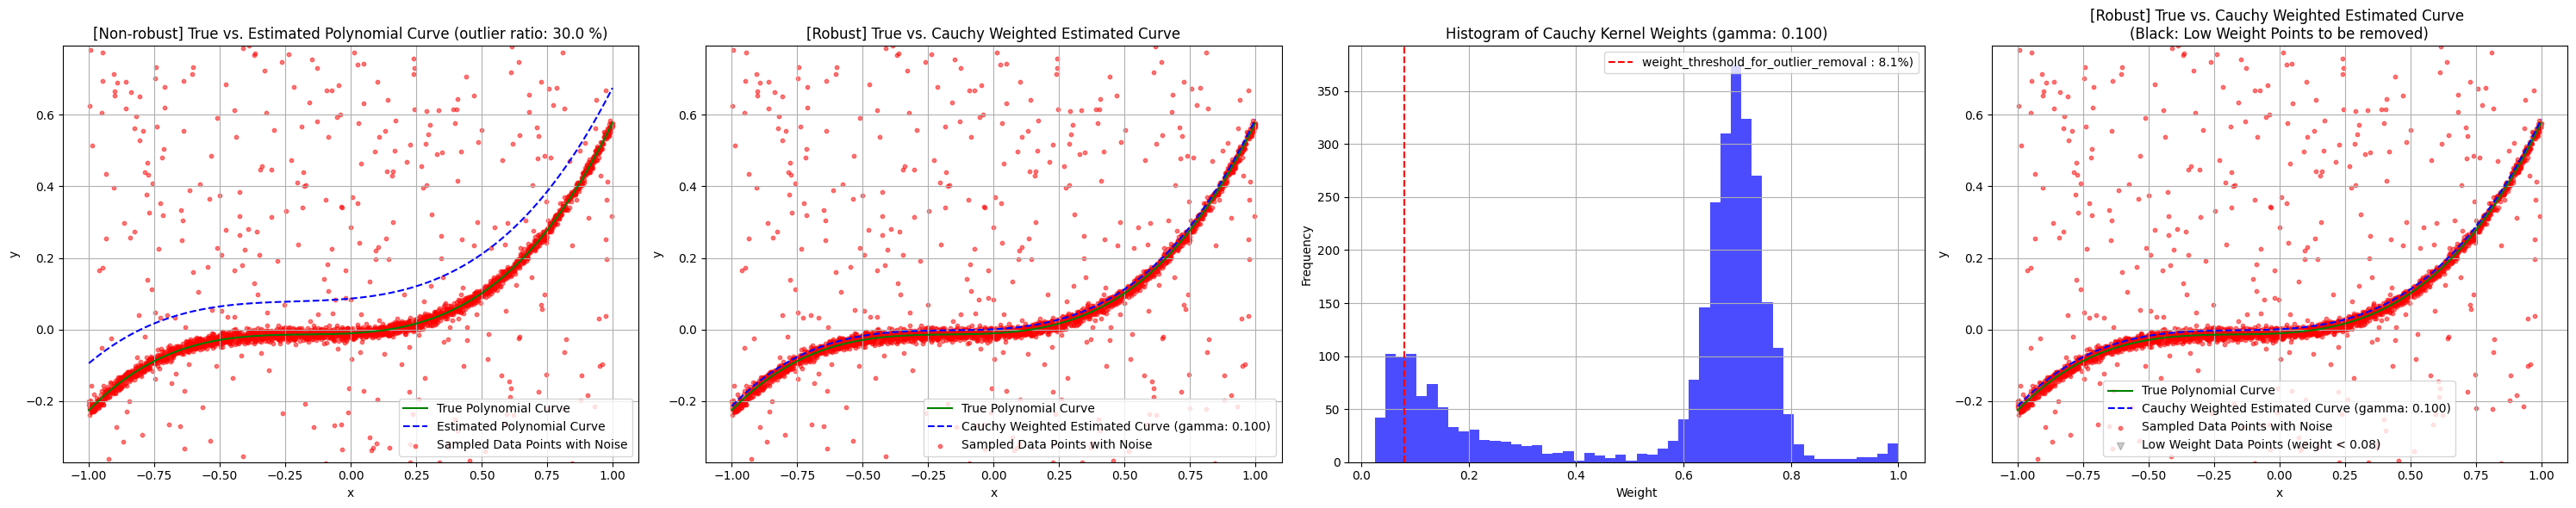

Try 1 remained num datapoints: 2775
weight_threshold_for_outlier_removal: 0.154


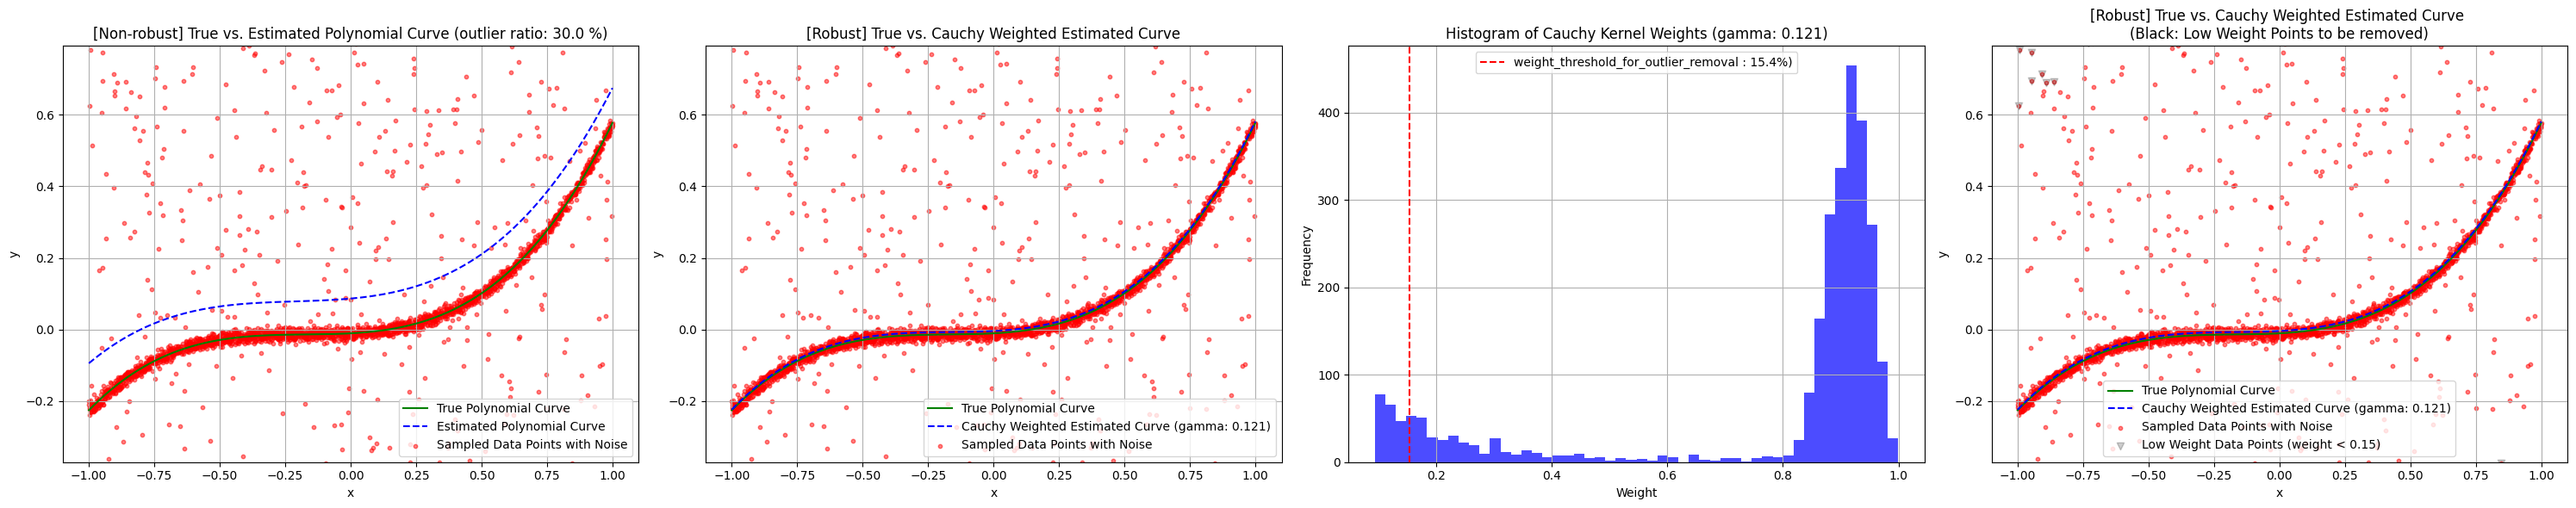

Try 2 remained num datapoints: 2566
weight_threshold_for_outlier_removal: 0.304


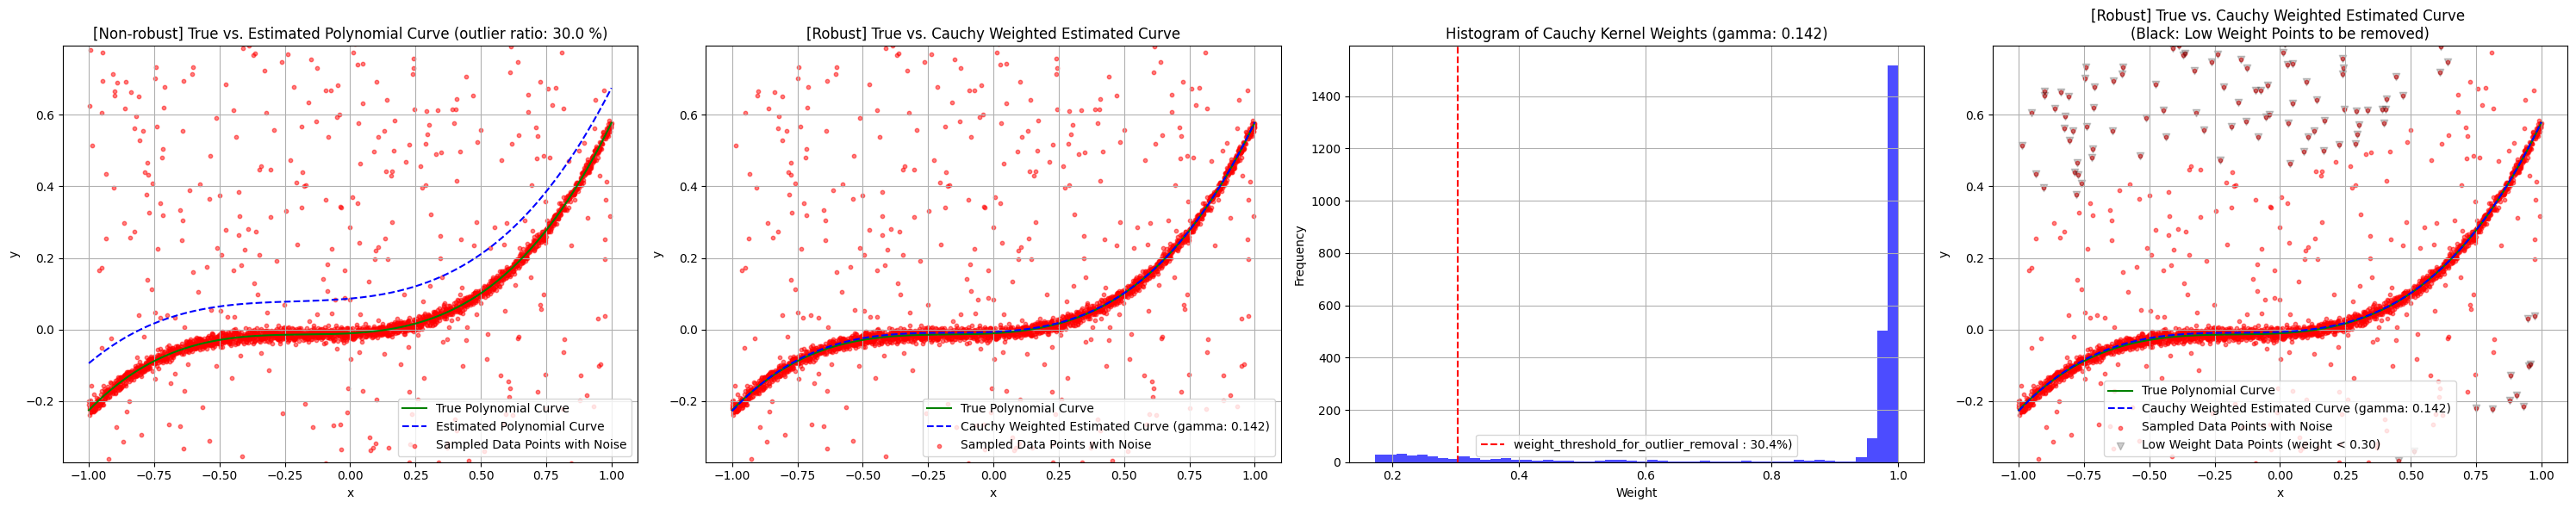

Try 3 remained num datapoints: 2373
weight_threshold_for_outlier_removal: 0.750


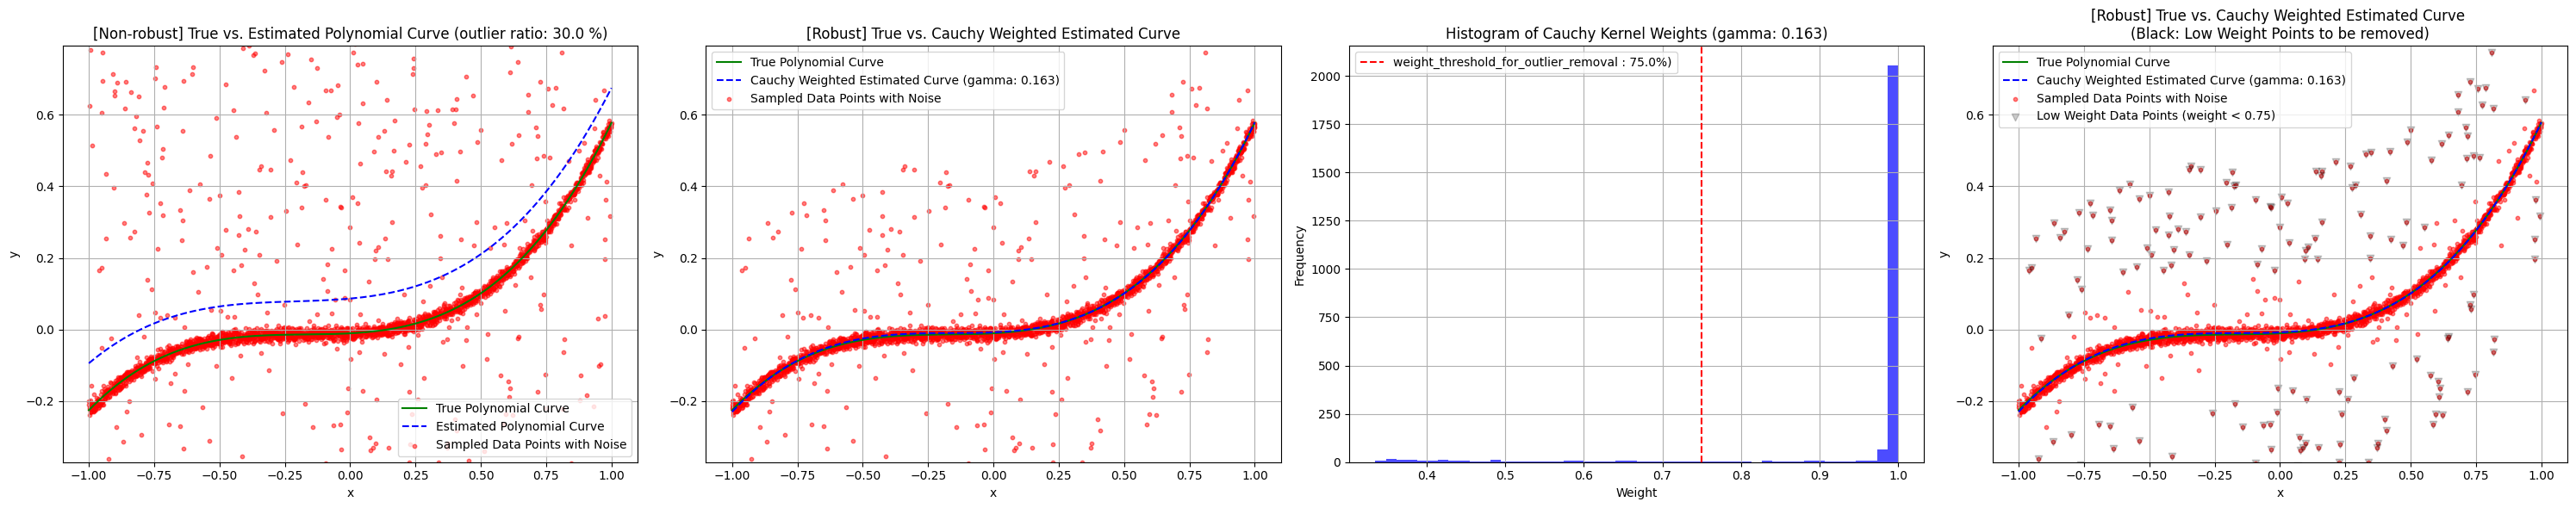

Try 4 remained num datapoints: 2195
weight_threshold_for_outlier_removal: 0.994


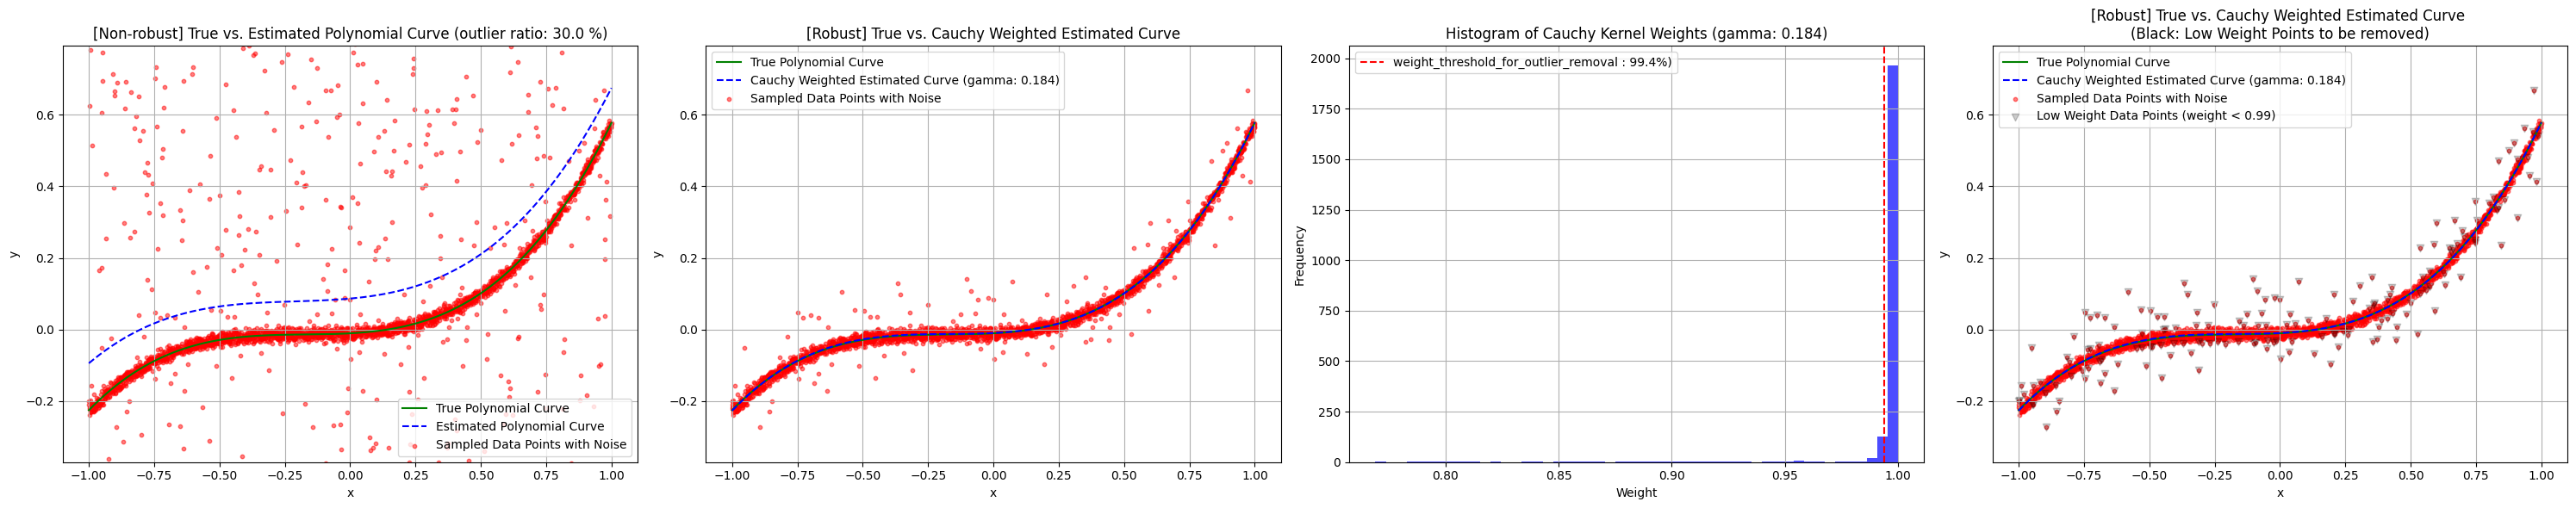

Try 5 remained num datapoints: 2030
weight_threshold_for_outlier_removal: 0.997


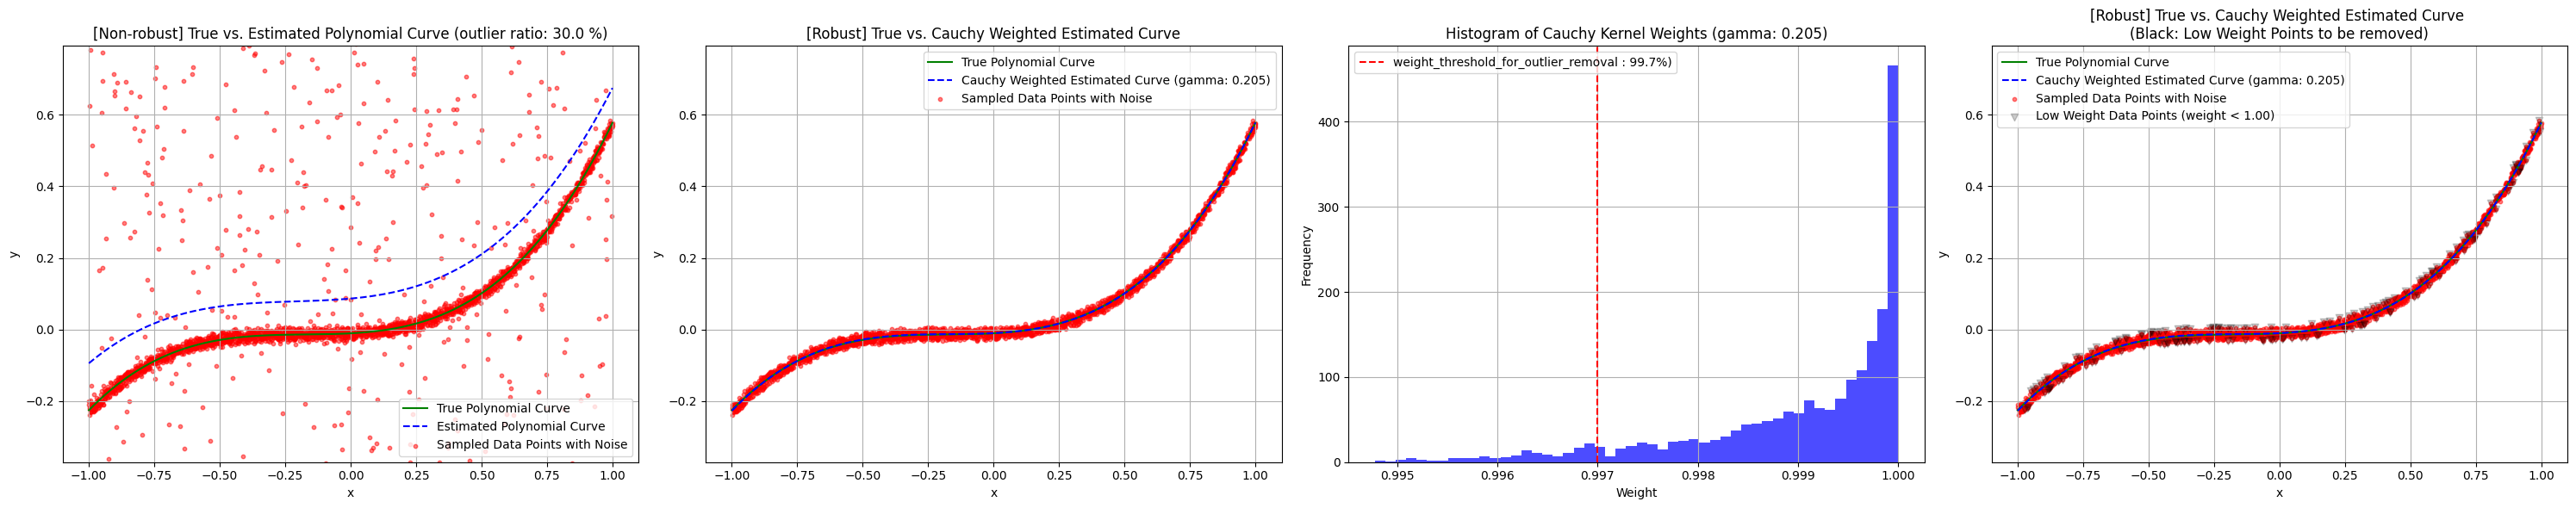

Try 6 remained num datapoints: 1877
weight_threshold_for_outlier_removal: 0.998


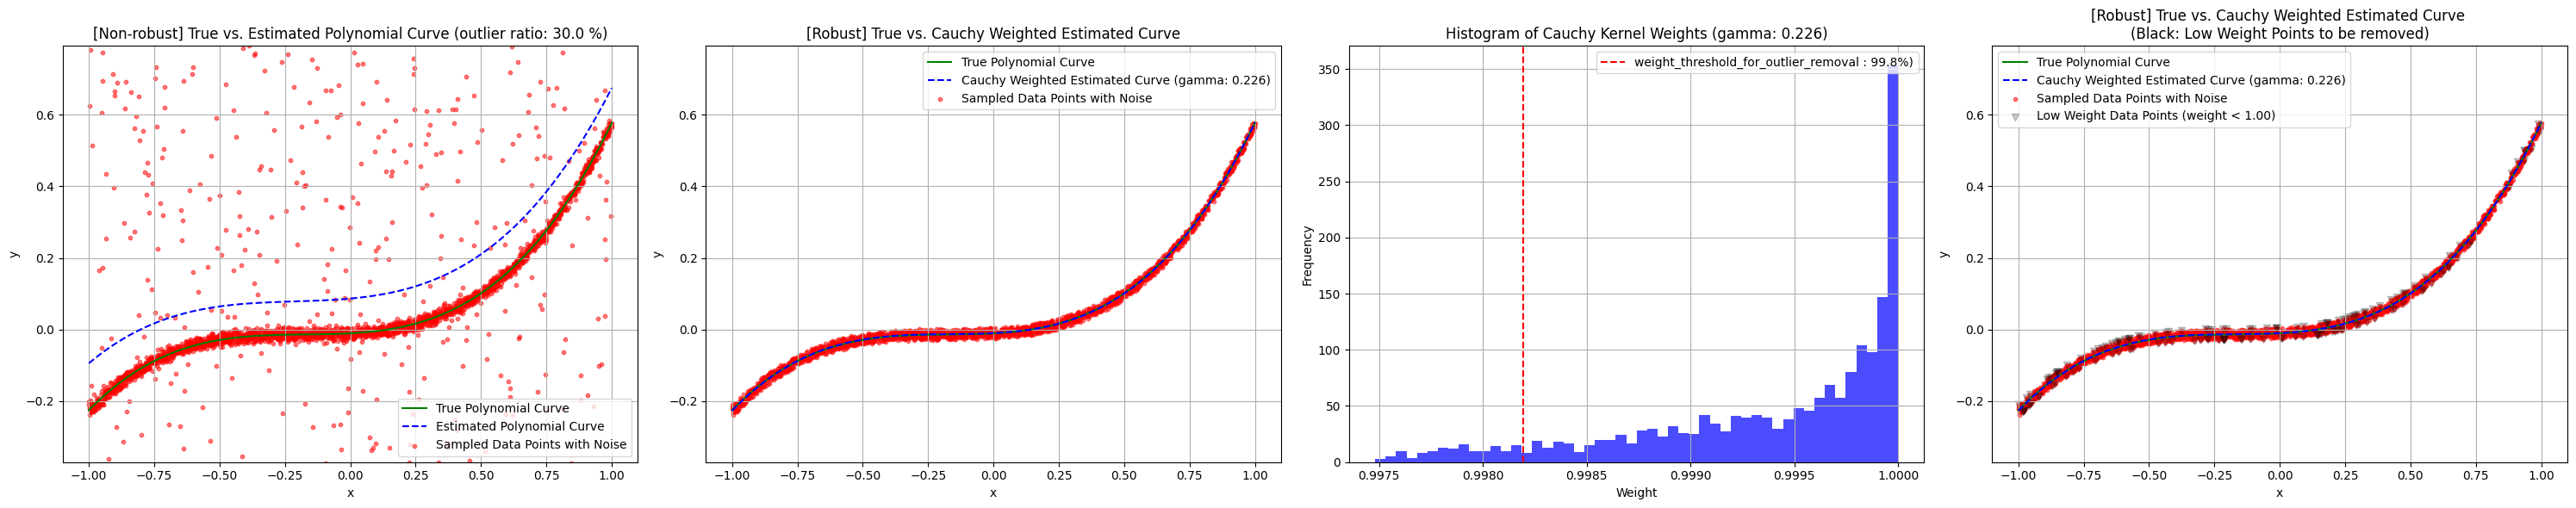

Try 7 remained num datapoints: 1736
weight_threshold_for_outlier_removal: 0.999


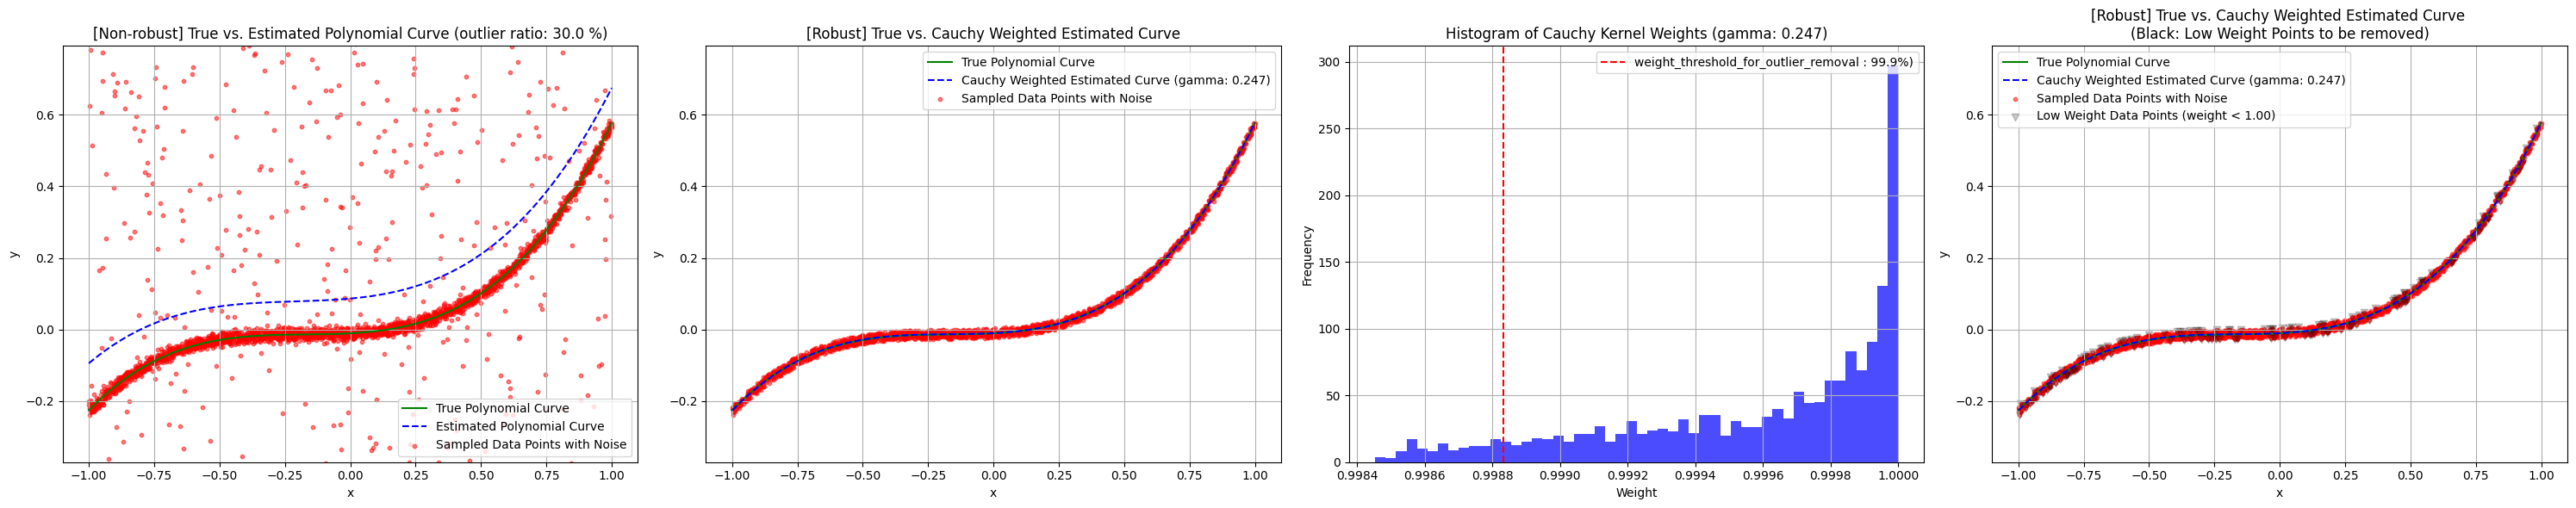

Try 8 remained num datapoints: 1605
weight_threshold_for_outlier_removal: 0.999


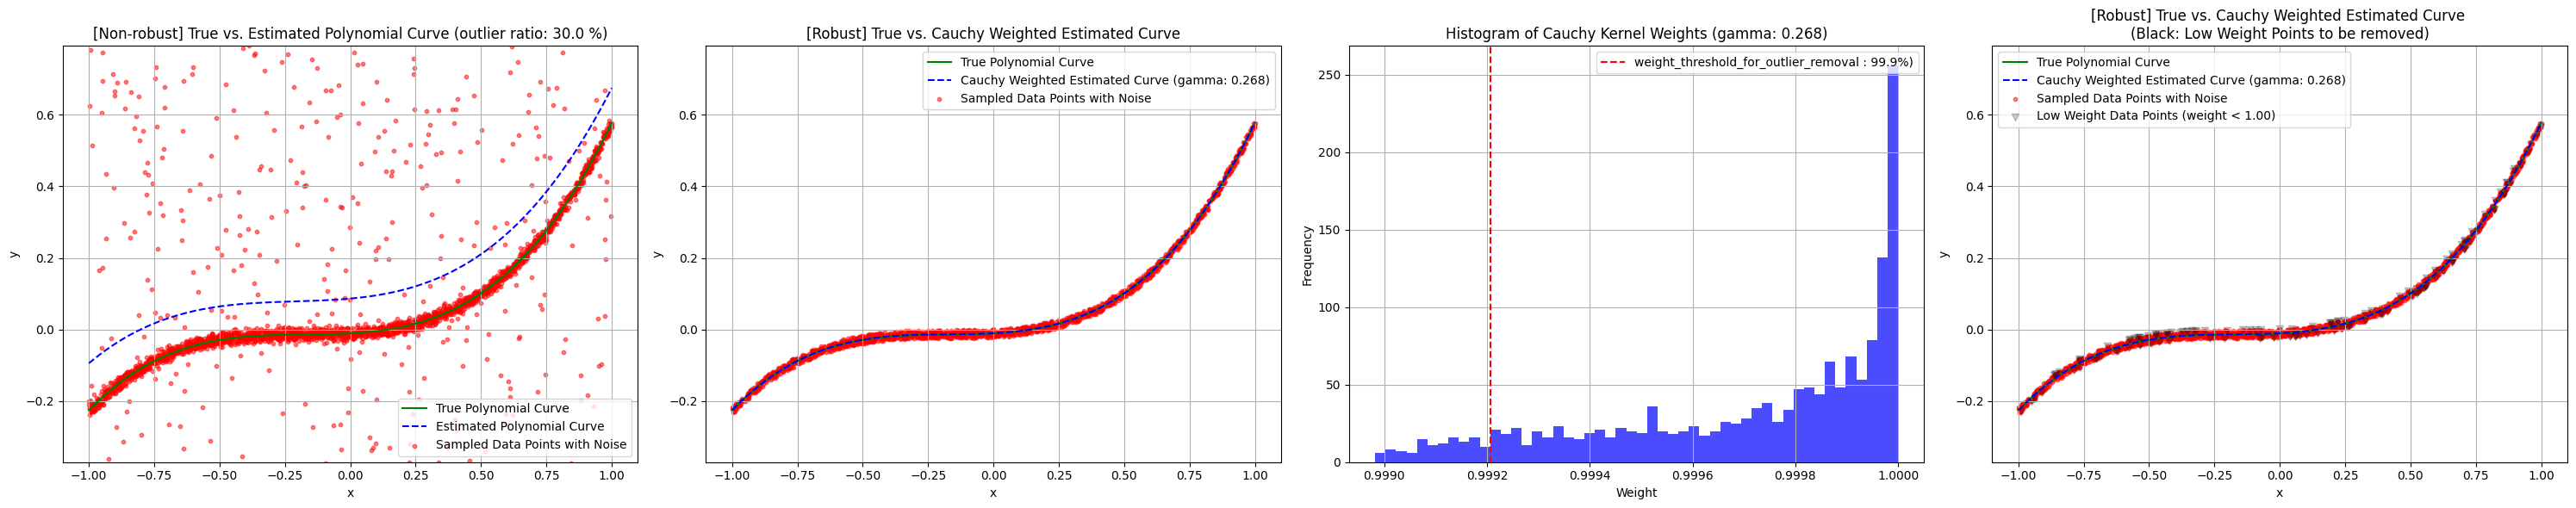


Converged. Stop the iterative-outlier-removal-based optimization.
The estimated value is
 [ 0.36346895  0.18642477  0.03848074 -0.0105031 ]
The true answer is
 [ 0.36157849  0.18668092  0.03994031 -0.0107759 ]
The estimated error is
 [0.00189046 0.00025614 0.00145957 0.0002728 ]


In [6]:
x_samples_orig = x_samples.copy()
y_samples_noisy_orig = y_samples_noisy.copy()

# The scale parameter of the Cauchy kernel, which can be adjusted to fit the data.
for ii, gamma in enumerate(np.linspace(0.1, 0.5, 20)):
    print('Try', ii, 'remained num datapoints:', x_samples.shape[0])

    # Calculate initial predictions (here we use simple least squares)
    coefficients_initial, _, _, _ = lstsq(A, b)
    y_initial_predicted = np.polyval(coefficients_initial, x_samples)

    # Calculating Cauchy kernel weights
    residuals_initial = y_samples_noisy - y_initial_predicted
    weights_cauchy = 1 / (1 + (residuals_initial / gamma) ** 2)
    weights_cauchy = np.sqrt(weights_cauchy) # empirically much smoother converge 
    
    # Apply weights
    W_cauchy = np.diag(weights_cauchy)
    WA_cauchy = W_cauchy @ A
    Wb_cauchy = W_cauchy @ b

    # Solving weighted linear systems
    coefficients_cauchy, _, _, _ = lstsq(WA_cauchy, Wb_cauchy)

    # Generate weighted predicted curves
    y_cauchy_estimated = np.polyval(coefficients_cauchy, x_samples)

    # Create a single figure for the subplots with a width equal to your monitor's width
    fig, axes = plt.subplots(1, 4, figsize=(30, 6))

    # Plot 1: True vs. Estimated Polynomial Curve
    axes[0].plot(x_samples_orig, y_samples, color='green', 
                 label='True Polynomial Curve')
    axes[0].plot(x_samples_orig, y_estimated, color='blue', linestyle='--', 
                 label='Estimated Polynomial Curve')
    axes[0].scatter(x_samples_orig, y_samples_noisy_orig, color='red', s=10, alpha=0.5, 
                    label='Sampled Data Points with Noise')
    axes[0].set_title(f'[Non-robust] True vs. Estimated Polynomial Curve (outlier ratio: {outlier_ratio*100:.1f} %)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend()
    axes[0].set_ylim(y_range.min, y_range.max)
    axes[0].grid(True)

    # Plot 2: True vs. Cauchy Weighted Estimated Curve
    axes[1].plot(x_samples_orig, y_samples, color='green', label='True Polynomial Curve')
    axes[1].plot(x_samples, y_cauchy_estimated, color='blue', linestyle='--', 
                 label=f'Cauchy Weighted Estimated Curve (gamma: {gamma:.3f})')
    axes[1].scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, 
                    label='Sampled Data Points with Noise')
    axes[1].set_title(f'[Robust] True vs. Cauchy Weighted Estimated Curve')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_ylim(y_range.min, y_range.max)
    axes[1].legend()
    axes[1].grid(True)

    # Plot 3: Histogram of Cauchy Kernel Weights
    axes[2].hist(weights_cauchy, bins=50, color='blue', alpha=0.7)
    axes[2].set_title(f'Histogram of Cauchy Kernel Weights (gamma: {gamma:.3f})')
    axes[2].set_xlabel('Weight')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)

    # Calculate the threshold value for the outlier_ratio
    outlier_ratio_damper_for_slow_removal = 0.25

    weight_threshold_for_outlier_removal = np.percentile(
        weights_cauchy, 
        100 * outlier_ratio * outlier_ratio_damper_for_slow_removal)
    if weight_threshold_for_outlier_removal < 0:
        weight_threshold_for_outlier_removal = 1.0
    print(f"weight_threshold_for_outlier_removal: {weight_threshold_for_outlier_removal:.3f}")

    # Plot the threshold line on the histogram
    axes[2].axvline(x=weight_threshold_for_outlier_removal, color='red', linestyle='--', 
                    label=f'weight_threshold_for_outlier_removal : {weight_threshold_for_outlier_removal * 100:.1f}%)')
    axes[2].legend()

    # Plot 4: True vs. Cauchy Weighted Estimated Curve with Low Weight Points
    # Find the indices of data points with weights less than k
    low_weight_indices = np.where(weights_cauchy < weight_threshold_for_outlier_removal)[0]
    # Extract x values ​​of data points with weights less than k
    x_low_weight = x_samples[low_weight_indices]
    y_low_weight_noisy = y_samples_noisy[low_weight_indices]
    axes[3].plot(x_samples_orig, y_samples, color='green', label='True Polynomial Curve')
    axes[3].plot(x_samples, y_cauchy_estimated, color='blue', linestyle='--', 
                 label=f'Cauchy Weighted Estimated Curve (gamma: {gamma:.3f})')
    axes[3].scatter(x_samples, y_samples_noisy, color='red', s=10, alpha=0.5, 
                    label='Sampled Data Points with Noise')
    axes[3].scatter(x_low_weight, y_low_weight_noisy, color='black', marker='v', alpha=0.2, 
                    label=f'Low Weight Data Points (weight < {weight_threshold_for_outlier_removal:.2f})')
    axes[3].set_title(f'[Robust] True vs. Cauchy Weighted Estimated Curve \n(Black: Low Weight Points to be removed)')
    axes[3].set_xlabel('x')
    axes[3].set_ylabel('y')
    axes[3].set_ylim(y_range.min, y_range.max)
    axes[3].legend()
    axes[3].grid(True)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Display the combined figure
    plt.show()

    if 0.999 < weight_threshold_for_outlier_removal:
        print("\nConverged. Stop the iterative-outlier-removal-based optimization.")
        print(f"The estimated value is\n {coefficients_cauchy}")
        print(f"The true answer is\n {coefficients}")
        print(f"The estimated error is\n {np.abs(coefficients_cauchy - coefficients)}")
        break
    else:
        # recursive removal 
        high_weight_indices = np.where(weight_threshold_for_outlier_removal 
                                    < weights_cauchy)[0]
        # Extract x values ​​of data points with weights less than k
        x_samples = x_samples[high_weight_indices]
        y_samples_noisy = y_samples_noisy[high_weight_indices]
        
        # Create matrix A and vector b re
        # Create Vandermonde matrix based on x_samples
        """
        # For example, x = np.array([1, 2, 3, 4]), and N = 2. It will output
        # [[ 1  1  1]
        #  [ 4  2  1]
        #  [ 9  3  1]
        #  [16  4  1]]
        # From the right to left, x^0, x^1, x^2. 
        """

        A = np.vander(x_samples, N = degree + 1)

        # b is the sampled data point with added noise
        b = y_samples_noisy

Summary from the video

* After remove the low weight data point during iteration, the performance is improved. 